## The modelling error is:
$$\delta e_{sys} = (e-e_{PSF}) \left( \frac{T_{PSF}}{T_{gal}} \right) \frac{\delta T_{PSF}}{T_{PSF}} - \left( \frac{T_{PSF}}{T_{gal}} \right)\delta e_{PSF}$$


## Propagate into shear errors:
$\rho$ statistics:

$$\rho_1 = \left\langle \delta e_{PSF}^*(x) \; \delta e_{PSF} (x+\theta) \right\rangle$$

$$\rho_2 = \left\langle e_{PSF}^* (x) \; \delta e_{PSF} (x+\theta) \right\rangle $$
$$\rho_3 = \left\langle \left( e_{PSF}^*   \frac{\delta T_{PSF}}{T_{PSF}}\right)(x) \; \left(e_{PSF}   \frac{\delta T_{PSF}}{T_{PSF}}\right)(x+\theta)\right\rangle $$
$$\rho_4 = \left\langle \delta e_{PSF}^* (x)\;\left( e_{PSF} \frac{\delta T_{PSF}}{T_{PSF}}\right)(x+\theta)\right\rangle $$
$$\rho_5 = \left\langle e_{PSF}^* (x)\; \left(e_{PSF} \frac{\delta T_{PSF}}{T_{PSF}}\right)(x+\theta) \right\rangle $$

Then

$$\delta \xi_+ (\theta) = 2 \left\langle \frac{T_{PSF}}{T_{gal}} \frac{\delta T_{PSF}}{T_{PSF}} \right\rangle \xi_+(\theta)
 + \left\langle \frac{T_{PSF}}{T_{gal}} \right\rangle^2 \rho_1(\theta)
 - \alpha\left\langle\frac{T_{PSF}}{T_{gal}}\right\rangle \rho_2(\theta) 
 + \left\langle \frac{T_{PSF}}{T_{gal}} \right\rangle^2 \rho_3(\theta)
 + \left\langle \frac{T_{PSF}}{T_{gal}} \right\rangle^2 \rho_4(\theta)
 - \alpha\left\langle\frac{T_{PSF}}{T_{gal}}\right\rangle \rho_5(\theta) 
$$

In [88]:
from __future__ import division
%pylab inline
from angles import r2d, r2arcs, d2arcs
import seaborn as sns;sns.set_style('darkgrid')
import lsst.sims.maf.stackers as stackers
import treecorr as tr, healpy as hp
import treecorr
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.figsize'] = 18,12
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.db as db
from lsst.sims.maf.plots import PlotHandler
from collections import defaultdict
sns.set_context('poster',font_scale=2)

class ModelErrors():
    
    def __init__(self,ModelType,WorstCase):
        self.fwhm = 0.7 #arcsec
        self.sigma = self.fwhm/(2*np.sqrt(2*np.log(2)))
        self.TrM = 2*self.sigma**2
        self.PSF.TrM = self.TrM
        self.STAR.TrM = self.TrM
        self.alpha = None 
        self.ModelType = ModelType
        self.survey_area = (np.radians(200),np.radians(50)) # in radians
        stars_X = np.random.rand(int(2000))*self.survey_area[0] 
        Y = 0.77*np.random.rand(int(2000))/2 + 0.5  #*self.survey_area[1] - self.survey_area[1]
        stars_Y = np.arccos(2*Y-1) -np.pi/2
        stars = np.array((stars_X,stars_Y))
        self.stars = stars.swapaxes(1,0)
        self.DELTA.e = defaultdict(list)
        self.DELTA.M = defaultdict(list)
        self.STAR.M = defaultdict(list)
        self.STAR.e = defaultdict(list)
        self.PSF.M = defaultdict(list)
        self.PSF.e = defaultdict(list)
        self.WorstCase = WorstCase
        self.e = defaultdict(float)
        
    class PSF:
        '''empty class to organise results into
        '''
        pass
    
    class STAR:
        '''empty class to organise results into
        '''
        pass
    
    class DELTA:
        '''empty class to organise results into
        '''
        pass

    def getModels(self):
        '''calls one of the model methods to create an overly simplified model, 
        or (N/A yet) imports one
        '''
        if self.WorstCase==False:
            for i in range(len(self.positions)):
                self.radial_pattern(position_num=i)
        else:
            for i in range(len(self.positions)):
                self.WorstCase_radial(position_num=i)
    def getPositions(self,sqlWhere,database='/Users/myhome/Downloads/minion_1016_sqlite.db'):
        '''uses OpSim to find all dithered positions given some constraint sqlWhere'''
        opsdb = db.OpsimDatabase(database)
        pos = opsdb.fetchMetricData(('ditheredRA', 'ditheredDec'), sqlconstraint=sqlWhere)
        pos = np.array(pos)
        if any(row[1] == x for row in pos):
            posRA = zip(*pos)[1]
        if any(row[2] == x for row in pos):
            posDec = zip(*pos)[2]
        pos = np.array((posRA,posDec))
        self.positions = pos.swapaxes(1,0)
        print 'number of stars dither positions: ', len(self.positions)
        
    def avgOver(self):
        ''' averages the shapes in 2nd moment-space 
        '''
        for pos in self.PSF.M.keys(): 
            try:
                self.DELTA.M[pos] = (np.mean(self.STAR.M[pos][0])-np.mean(self.PSF.M[pos][0]),\
                                 np.mean(self.STAR.M[pos][1])-np.mean(self.PSF.M[pos][1]),\
                                 np.mean(self.STAR.M[pos][2])-np.mean(self.PSF.M[pos][2])\
                                )
                self.STAR.M[pos] = np.array([np.mean([x[0] for x in self.STAR.M[pos]]), np.mean([x[1] for x in self.STAR.M[pos]]), np.mean([x[2] for x in self.STAR.M[pos]])])
                self.PSF.M[pos] = np.array([np.mean([x[0] for x in self.PSF.M[pos]]), np.mean([x[1] for x in self.PSF.M[pos]]), np.mean([x[2] for x in self.PSF.M[pos]])])
                print self.PSF.M[pos]
                self.DELTA.M[pos] = self.STAR.M[pos] - self.PSF.M[pos]
                print self.DELTA.M[pos]
            except:
                print 'problem'
                pass
#         for pos in self.PSF.e.keys():
#             try:
#                 self.PSF.e[pos] = (np.mean(self.PSF.e[pos][0]), np.mean(self.PSF.e[pos][1]))
#             except:
#                 pass
            
    def M2e(self):
        for pos in self.DELTA.M.keys():
            Mxx, Mxy, Myy = self.DELTA.M[pos]
            self.DELTA.e[pos] = ((Mxx-Myy)/self.PSF.TrM, Mxy*2/self.PSF.TrM)
            Mxx, Mxy, Myy = self.STAR.M[pos]
            self.STAR.e[pos] = ((Mxx-Myy)/self.STAR.TrM, Mxy*2/self.STAR.TrM)
            Mxx, Mxy, Myy = self.PSF.M[pos]
            self.PSF.e[pos] = ((Mxx-Myy)/self.PSF.TrM, Mxy*2/self.PSF.TrM)
            print Mxx,Mxy,Myy, self.PSF.e[pos]
    def process(self,sqlWhere):
        ''' runs all analysis methods 
        '''
        self.getPositions(sqlWhere)
        self.getModels()
        if self.WorstCase==False:
            self.avgOver()
            self.M2e()
        self.getRhos()
        #self.rhos2errors()
        
        
    def getRhos(self):
        ''' method to get the rho statistics, needs a model, and traces for rhos 2 through 5.
        '''
        X = [key[0] for key in self.DELTA.e.keys()]
        Y = [key[1] for key in self.DELTA.e.keys()]
        de1 = [val[0] for val in self.DELTA.e.values()]
        de2 = [val[1] for val in self.DELTA.e.values()]
        psfe1 = [val[0] for val in self.PSF.e.values()]
        psfe2 = [val[1] for val in self.PSF.e.values()]
#         psfe = [val for val in self.PSF.e.values()]
#         psfe1,psfe2 = [[0 for _ in range(len(self.PSF.e.keys()))] for _ in range(2)]
#         lst = [val for val in self.PSF.e.values()]
#         for i,val in enumerate(lst):
#             if type(val)==tuple:
#                 pass
#             else:
#                 lst[i] = val[0]
#         for i in range(len(lst)):
#             psfe1[i] = lst[i][0]
#             psfe2[i] = lst[i][1]
        decat = treecorr.Catalog(g1=de1, g2=de2, ra=X, dec=Y, ra_units='radians', dec_units='radians')
        psfcat = treecorr.Catalog(g1=psfe1, g2=psfe2, ra=X, dec=Y, ra_units='radians', dec_units='radians')

        dedecorr = treecorr.GGCorrelation(min_sep=0.1, max_sep=50, nbins=20, sep_units='degrees')
        dedecorr.process(decat)
        dede_xip = dedecorr.xip
        dede_xim = dedecorr.xim
        self.rho1_sigma = dedecorr.varxi**0.5
        self.r = np.exp(dedecorr.meanlogr)
        self.rho1 = dede_xip
        self.rho1_im = dede_xim
        

        edecorr = treecorr.GGCorrelation(min_sep=0.1, max_sep=50, nbins=20, sep_units='degrees')
        edecorr.process(psfcat, decat)
        ede_xip = edecorr.xip
        ede_xim = edecorr.xim
        
        self.rho2 = ede_xip
        self.rho2_im = ede_xim
        self.rho2_sigma = edecorr.varxi**0.5
        
        self.size_error_ratio = 0.01

        edtedtcorr = treecorr.GGCorrelation(min_sep=0.1, max_sep=50, nbins=20, sep_units='degrees')
        edtedtcorr.process(psfcat*self.size_error_ratio, psfcat*self.size_error_ratio)
        edtedt_xip = edtedtcorr.xip
        edtedt_xim = edtedtcorr.xim
        
        self.rho3 = edtedt_xip
        self.rho3_im = edtedt_xim
        
        deedtcorr = treecorr.GGCorrelation(min_sep=0.1, max_sep=50, nbins=20, sep_units='degrees')
        deedtcorr.process(decat, psfcat*self.size_error_ratio)
        deedt_xip = deedtcorr.xip
        deedt_xim = deedtcorr.xim
        
        self.rho4 = deedt_xip
        self.rho4_im = deedt_xim
        
        eedtcorr = treecorr.GGCorrelation(min_sep=0.1, max_sep=50, nbins=20, sep_units='degrees')
        eedtcorr.process(psfcat, psfcat*self.size_error_ratio)
        eedt_xip = eedtcorr.xip
        eedt_xim = eedtcorr.xim
        
        self.rho5 = eedt_xip
        self.rho5_im = eedt_xim
            
            
    def rhos2errors(self):
        ''' propagates rho statistics into shear errors 
        '''
        self.delta_xip = 2 * (self.delta_T_psf/self.T_gal) * self.xip\
                    + (self.T_PSF/self.T_gal)**2 * rho1\
                    - self.alpha * (self.T_PSF/self.T_gal) * self.rho2\
                    + (self.T_PSF/self.T_gal)**2 * self.rho3\
                    + (self.T_PSF/self.T_gal)**2 * self.rho4\
                    - self.alpha * (self.T_PSF/self.T_gal) * self.rho5
                    
    def radial_pattern(self,position_num):
        ''' method to create a radial pattern (one of the overly simplified models),
            e = 0.05* distance from origin
        '''
        from angles import r2d, r2arcs, d2arcs
        center = self.positions[position_num]
        stars = self.stars[np.where(((self.stars[:,0]-center[0])**2+(self.stars[:,1]-center[1])**2)<np.radians(1.2))[0]] 
        rel_X, rel_Y = stars[:,0] - center[0], stars[:,1] - center[1]
        r = np.sqrt(rel_X**2+rel_Y**2)
        theta = np.arctan((rel_Y)/(rel_X))
        stare1 = r*np.cos(2*theta)/2
        stare2 = r*np.sin(2*theta)/2
        psfe1 = stare1/1.03
        psfe2 = stare2/1.03
        starMxx = 0.5*self.STAR.TrM*(stare1+1)
        starMxy = 0.5*self.STAR.TrM*stare2
        starMyy = 0.5*self.STAR.TrM*(-stare1+1)
        psfMxx = 0.5*self.PSF.TrM*(psfe1+1)
        psfMxy = 0.5*self.PSF.TrM*psfe2
        psfMyy = 0.5*self.PSF.TrM*(-psfe1+1)
        # populate new defaultdict with star/psf M[pos]=(Mxx,Mxy,Myy)
        for i in range(len(psfMxx)):
            self.STAR.M[(stars[i][0],stars[i][1])].append((starMxx[i],starMxy[i],starMyy[i]))
            self.PSF.M[(stars[i][0],stars[i][1])].append((psfMxx[i],psfMxy[i],psfMyy[i]))
            
#             self.STAR.M[(stars[i][0],stars[i][1])].append((starMxx[i],starMxy[i],starMyy[i]))
#             self.STAR.e[(stars[i][0],stars[i][1])].append((stare1[i],stare2[i]))
        # print np.mean(np.sqrt(stare1**2+stare2**2))
    
    def WorstCase_radial(self,position_num):
        from angles import r2d, r2arcs, d2arcs
        center = self.positions[position_num]
        stars = self.stars[np.where(((self.stars[:,0]-center[0])**2+(self.stars[:,1]-center[1])**2)<np.radians(1.2))[0]] 
        rel_X, rel_Y = stars[:,0] - center[0], stars[:,1] - center[1]
        r = np.sqrt(rel_X**2+rel_Y**2)
        theta = np.arctan((rel_Y)/(rel_X))
        stare1 = r*np.cos(2*theta)/2
        stare2 = r*np.sin(2*theta)/2
        psfe1 = stare1/1.03
        psfe2 = stare2/1.03
        de1 = stare1 - psfe1
        de2 = stare2 - psfe2
        for i in range(len(psfe2)):
            if (stars[i][0],stars[i][1]) in self.e.keys():
                pass
            else:
                self.e[(stars[i][0],stars[i][1])]=(de1[i],de2[i])
                self.STAR.e[(stars[i][0],stars[i][1])]=(stare1[i],stare2[i])
    
    def horizontal_pattern(self): ## untested for new algorithm
        ''' method to create a horizontal pattern (one of the overly simplified models) 
            e = 0.1
        '''
        from angles import r2d, r2arcs, d2arcs
        e1 = np.ones(1000)*0.1
        e2 = np.zeros(len(self.stars_X))
        return e1,e2
    
    # I should probably combine both patterns into a single method. 



Populating the interactive namespace from numpy and matplotlib


In [89]:
best_case = ModelErrors('radial',WorstCase=False)

In [90]:
best_case.getPositions(sqlWhere='filter = "r" and night < 40000 and fieldRA < %f and fieldDec > %f and fieldRA > 0 and fieldDec < 0' % (np.radians(200), np.radians(-50)))

number of stars dither positions:  231968


In [91]:
best_case.getModels()

In [92]:
best_case.avgOver()

[  8.83731684e-02  -6.56304459e-05   8.83569741e-02]
[  2.42915842e-07  -1.96891338e-06  -2.42915842e-07]
[  8.83502781e-02   5.86049535e-06   8.83798644e-02]
[ -4.43794848e-07   1.75814860e-07   4.43794848e-07]
[  8.83745275e-02  -9.63759297e-05   8.83556150e-02]
[  2.83687265e-07  -2.89127789e-06  -2.83687265e-07]
[ 0.08967281 -0.00037588  0.08705734]
[  3.92320843e-05  -1.12764576e-05  -3.92320843e-05]
[  8.83986374e-02   8.15207848e-06   8.83315051e-02]
[  1.00698315e-06   2.44562355e-07  -1.00698315e-06]
[  8.83535704e-02  -5.96567709e-05   8.83765721e-02]
[ -3.45026662e-07  -1.78970313e-06   3.45026662e-07]
[  8.83998899e-02  -3.66922083e-05   8.83302526e-02]
[  1.04456045e-06  -1.10076625e-06  -1.04456045e-06]
[  8.83316207e-02  -3.69079068e-05   8.83985218e-02]
[ -1.00351748e-06  -1.10723721e-06   1.00351748e-06]
[  8.82847849e-02  -1.67079964e-05   8.84453576e-02]
[ -2.40858944e-06  -5.01239891e-07   2.40858944e-06]
[  8.86917097e-02  -6.73439422e-07   8.80384328e-02]
[  9.799

[ -1.95231982e-07  -1.46298894e-06   1.95231982e-07]
[  8.83359059e-02   2.66438869e-05   8.83942367e-02]
[ -8.74961913e-07   7.99316607e-07   8.74961913e-07]
[ 0.08772756  0.00049019  0.08900259]
[ -1.91254129e-05   1.47056736e-05   1.91254129e-05]
[  8.83483214e-02  -1.95741289e-05   8.83818211e-02]
[ -5.02495748e-07  -5.87223867e-07   5.02495748e-07]
[  8.86884849e-02   2.54044093e-05   8.80416576e-02]
[  9.70240920e-06   7.62132278e-07  -9.70240920e-06]
[  8.83420116e-02  -3.55749373e-05   8.83881309e-02]
[ -6.91788509e-07  -1.06724812e-06   6.91788509e-07]
[  8.86236892e-02   6.75387244e-05   8.81064533e-02]
[  7.75853898e-06   2.02616173e-06  -7.75853898e-06]
[  8.83785803e-02   2.12686844e-05   8.83515622e-02]
[  4.05271009e-07   6.38060533e-07  -4.05271009e-07]
[  8.90075623e-02  -6.63486529e-05   8.77225802e-02]
[  1.92747303e-05  -1.99045959e-06  -1.92747303e-05]
[  8.83592769e-02  -3.52541879e-05   8.83708656e-02]
[ -1.73831803e-07  -1.05762564e-06   1.73831803e-07]
[ 0.0884

[ -2.61849931e-06  -7.41772118e-07   2.61849931e-06]
[  8.83541336e-02   1.75428504e-06   8.83760089e-02]
[ -3.28128650e-07   5.26285511e-08   3.28128650e-07]
[  8.82904873e-02   1.94765968e-06   8.84396552e-02]
[ -2.23751975e-06   5.84297903e-08   2.23751975e-06]
[  8.83414287e-02  -4.28420814e-05   8.83887138e-02]
[ -7.09276603e-07  -1.28526244e-06   7.09276603e-07]
[  8.83836459e-02   1.02038854e-05   8.83464966e-02]
[  5.57240140e-07   3.06116562e-07  -5.57240140e-07]
[  8.84034950e-02   2.06945984e-06   8.83266475e-02]
[  1.15271318e-06   6.20837951e-08  -1.15271318e-06]
[  8.83493826e-02   1.88403573e-05   8.83807599e-02]
[ -4.70659177e-07   5.65210720e-07   4.70659177e-07]
[  8.83241307e-02  -3.61626568e-05   8.84060118e-02]
[ -1.22821685e-06  -1.08487970e-06   1.22821685e-06]
[  8.83551946e-02  -3.81793115e-05   8.83749479e-02]
[ -2.96300148e-07  -1.14537934e-06   2.96300148e-07]
[  8.84050031e-02  -3.55556942e-05   8.83251394e-02]
[  1.19795687e-06  -1.06667083e-06  -1.1979568

[  8.83486318e-02  -4.96864761e-06   8.83815107e-02]
[ -4.93184185e-07  -1.49059428e-07   4.93184185e-07]
[  8.82871347e-02   8.73267962e-06   8.84430078e-02]
[ -2.33809720e-06   2.61980389e-07   2.33809720e-06]
[  8.83424364e-02  -1.94278344e-05   8.83877061e-02]
[ -6.79044615e-07  -5.82835032e-07   6.79044615e-07]
[  8.83623141e-02  -3.62514316e-05   8.83678284e-02]
[ -8.27151379e-08  -1.08754295e-06   8.27151380e-08]
[  8.83473242e-02   4.42229292e-05   8.83828184e-02]
[ -5.32413133e-07   1.32668788e-06   5.32413133e-07]
[  8.84417038e-02   1.00341407e-05   8.82884387e-02]
[  2.29897768e-06   3.01024220e-07  -2.29897768e-06]
[  8.83756923e-02  -1.26361867e-05   8.83544502e-02]
[  3.18631625e-07  -3.79085600e-07  -3.18631625e-07]
[ 0.08779903  0.00013759  0.08893112]
[ -1.69813621e-05   4.12781884e-06   1.69813621e-05]
[  8.83612246e-02   3.10221258e-06   8.83689179e-02]
[ -1.15399798e-07   9.30663773e-08   1.15399798e-07]
[  8.84409296e-02  -2.49101674e-05   8.82892129e-02]
[  2.275

[  8.86047572e-02   1.97522593e-05   8.81253854e-02]
[  7.19057694e-06   5.92567779e-07  -7.19057694e-06]
[  8.83644653e-02   2.94661534e-05   8.83656772e-02]
[ -1.81785057e-08   8.83984603e-07   1.81785057e-08]
[  8.90477693e-02   8.75798561e-05   8.76823732e-02]
[  2.04809404e-05   2.62739568e-06  -2.04809404e-05]
[  8.85755554e-02  -2.95518162e-06   8.81545871e-02]
[  6.31452405e-06  -8.86554485e-08  -6.31452405e-06]
[  8.89529523e-02   7.82176498e-05   8.77771902e-02]
[  1.76364307e-05   2.34652949e-06  -1.76364307e-05]
[  8.83701839e-02  -2.17277437e-05   8.83599586e-02]
[  1.53380542e-07  -6.51832311e-07  -1.53380542e-07]
[  8.85638435e-02  -3.95238219e-05   8.81662990e-02]
[  5.96316682e-06  -1.18571466e-06  -5.96316682e-06]
[ 0.08848611 -0.00130991  0.08824403]
[  3.63130518e-06  -3.92973448e-05  -3.63130518e-06]
[  8.83575826e-02  -4.99302972e-06   8.83725599e-02]
[ -2.24660755e-07  -1.49790892e-07   2.24660755e-07]
[  8.84156647e-02  -8.64531025e-06   8.83144778e-02]
[  1.517

[ -7.86967132e-07   2.38018091e-05   7.86967132e-07]
[  8.80965819e-02   5.65736668e-05   8.86335606e-02]
[ -8.05467971e-06   1.69721000e-06   8.05467971e-06]
[  8.86985239e-02   7.67336418e-05   8.80316186e-02]
[  1.00035790e-05   2.30200925e-06  -1.00035790e-05]
[ 0.08794294 -0.00016009  0.0887872 ]
[ -1.26638699e-05  -4.80274598e-06   1.26638699e-05]
[  8.83827534e-02  -3.34373439e-05   8.83473891e-02]
[  5.30464115e-07  -1.00312032e-06  -5.30464115e-07]
[  8.83405333e-02  -3.96374751e-05   8.83896092e-02]
[ -7.36138963e-07  -1.18912425e-06   7.36138963e-07]
[ 0.09051258  0.00066715  0.08621756]
[  6.44251980e-05   2.00145039e-05  -6.44251980e-05]
[  8.89418281e-02  -4.57178700e-05   8.77883144e-02]
[  1.73027045e-05  -1.37153610e-06  -1.73027045e-05]
[  8.83981099e-02   1.13850730e-05   8.83320326e-02]
[  9.91159357e-07   3.41552189e-07  -9.91159357e-07]
[  8.82920250e-02  -4.31088132e-05   8.84381176e-02]
[ -2.19138911e-06  -1.29326439e-06   2.19138912e-06]
[  8.87615310e-02   4.8

[ -8.41778358e-07   2.72349722e-07   8.41778358e-07]
[  8.88513879e-02  -1.88577580e-05   8.78787546e-02]
[  1.45895005e-05  -5.65732741e-07  -1.45895005e-05]
[  8.83758235e-02  -2.59961232e-05   8.83543190e-02]
[  3.22568610e-07  -7.79883695e-07  -3.22568610e-07]
[  8.90106835e-02  -5.65979217e-05   8.77194590e-02]
[  1.93683671e-05  -1.69793765e-06  -1.93683671e-05]
[  8.84912469e-02  -7.55085340e-06   8.82388957e-02]
[  3.78526796e-06  -2.26525602e-07  -3.78526796e-06]
[  8.83844749e-02   1.59721118e-05   8.83456676e-02]
[  5.82109048e-07   4.79163353e-07  -5.82109048e-07]
[  8.84734104e-02   4.26874592e-05   8.82567321e-02]
[  3.25017362e-06   1.28062378e-06  -3.25017362e-06]
[  8.77971820e-02   8.94845248e-05   8.89329605e-02]
[ -1.70366771e-05   2.68453574e-06   1.70366771e-05]
[  8.83403380e-02  -2.17847189e-06   8.83898045e-02]
[ -7.41996957e-07  -6.53541568e-08   7.41996957e-07]
[  8.83654698e-02   4.06800884e-06   8.83646727e-02]
[  1.19552521e-08   1.22040265e-07  -1.1955252

[ -1.33861436e-05   3.82706112e-05   1.33861436e-05]
[  8.83651611e-02   3.89263790e-05   8.83649814e-02]
[  2.69642147e-09   1.16779137e-06  -2.69642150e-09]
[  8.84286531e-02  -1.38696421e-05   8.83014894e-02]
[  1.90745454e-06  -4.16089262e-07  -1.90745454e-06]
[  8.89055010e-02  -1.97344277e-05   8.78246415e-02]
[  1.62128926e-05  -5.92032830e-07  -1.62128926e-05]
[  8.83389162e-02   5.84172304e-06   8.83912263e-02]
[ -7.84651526e-07   1.75251691e-07   7.84651526e-07]
[  8.83780557e-02  -3.70046368e-05   8.83520868e-02]
[  3.89534733e-07  -1.11013910e-06  -3.89534733e-07]
[ 0.0878613  -0.00173803  0.08886884]
[ -1.51130395e-05  -5.21409834e-05   1.51130395e-05]
[ 0.0882746  -0.00012792  0.08845555]
[ -2.71421747e-06  -3.83774634e-06   2.71421747e-06]
[  8.83700164e-02   3.60898901e-05   8.83601261e-02]
[  1.48353145e-07   1.08269670e-06  -1.48353145e-07]
[  8.83482530e-02  -8.74157773e-06   8.83818895e-02]
[ -5.04547746e-07  -2.62247332e-07   5.04547746e-07]
[  8.88526384e-02  -4.3

[  8.87765321e-02   5.26523162e-05   8.79536104e-02]
[  1.23438242e-05   1.57956949e-06  -1.23438242e-05]
[  8.83323293e-02   4.53544155e-05   8.83978132e-02]
[ -9.82259651e-07   1.36063247e-06   9.82259651e-07]
[  8.83792943e-02  -4.13880945e-05   8.83508482e-02]
[  4.26692121e-07  -1.24164283e-06  -4.26692121e-07]
[  8.83466918e-02  -5.61763100e-05   8.83834508e-02]
[ -5.51384933e-07  -1.68528930e-06   5.51384933e-07]
[  8.83725608e-02  -9.39686062e-06   8.83575818e-02]
[  2.24684915e-07  -2.81905818e-07  -2.24684915e-07]
[  8.83630599e-02   5.50110792e-06   8.83670826e-02]
[ -6.03405928e-08   1.65033238e-07   6.03405929e-08]
[ 0.08897329 -0.00013451  0.08775685]
[  1.82466898e-05  -4.03537208e-06  -1.82466898e-05]
[  8.87155979e-02  -1.15624433e-05   8.80145446e-02]
[  1.05158008e-05  -3.46873300e-07  -1.05158008e-05]
[  8.87324525e-02   5.87759577e-05   8.79976900e-02]
[  1.10214387e-05   1.76327873e-06  -1.10214387e-05]
[  8.77366189e-02  -7.84308031e-05   8.89935237e-02]
[ -1.885

[ 0.0889014   0.00029416  0.08782874]
[  1.60899440e-05   8.82469722e-06  -1.60899440e-05]
[  8.83171582e-02  -4.42329548e-05   8.84129843e-02]
[ -1.43739093e-06  -1.32698864e-06   1.43739093e-06]
[  8.83372033e-02  -2.73221698e-07   8.83929392e-02]
[ -8.36039785e-07  -8.19665095e-09   8.36039785e-07]
[  8.87541530e-02  -3.76018945e-06   8.79759895e-02]
[  1.16724523e-05  -1.12805683e-07  -1.16724523e-05]
[  8.90856510e-02   2.65992907e-05   8.76444915e-02]
[  2.16173921e-05   7.97978720e-07  -2.16173921e-05]
[  8.84633754e-02   7.62594726e-07   8.82667671e-02]
[  2.94912352e-06   2.28778418e-08  -2.94912352e-06]
[  8.90435640e-02  -6.51801736e-05   8.76865785e-02]
[  2.03547828e-05  -1.95540521e-06  -2.03547828e-05]
[  8.77224274e-02  -5.48609593e-05   8.90077152e-02]
[ -1.92793169e-05  -1.64582878e-06   1.92793169e-05]
[  8.89173624e-02   4.81422439e-05   8.78127801e-02]
[  1.65687346e-05   1.44426732e-06  -1.65687346e-05]
[  8.83994467e-02   1.20135054e-05   8.83306958e-02]
[  1.031

[  1.39090873e-05   1.97269293e-06  -1.39090873e-05]
[  8.83772450e-02   3.84095406e-05   8.83528975e-02]
[  3.65213513e-07   1.15228622e-06  -3.65213513e-07]
[ 0.08894044  0.00015141  0.0877897 ]
[  1.72611297e-05   4.54243572e-06  -1.72611297e-05]
[  8.83461516e-02  -2.27755825e-05   8.83839909e-02]
[ -5.67590551e-07  -6.83267474e-07   5.67590551e-07]
[  8.90267498e-02  -3.94462800e-05   8.77033927e-02]
[  1.98503576e-05  -1.18338840e-06  -1.98503576e-05]
[  8.88181645e-02  -6.21051453e-05   8.79119780e-02]
[  1.35927983e-05  -1.86315436e-06  -1.35927983e-05]
[  8.83219267e-02   1.74580227e-05   8.84082158e-02]
[ -1.29433649e-06   5.23740680e-07   1.29433649e-06]
[  8.85652325e-02   2.08524253e-05   8.81649100e-02]
[  6.00483763e-06   6.25572758e-07  -6.00483763e-06]
[  8.84378645e-02   6.24753075e-05   8.82922780e-02]
[  2.18379746e-06   1.87425922e-06  -2.18379746e-06]
[  8.83712328e-02  -2.03637997e-05   8.83589097e-02]
[  1.84845930e-07  -6.10913990e-07  -1.84845930e-07]
[  8.853

[  1.15628673e-05  -4.22089564e-06  -1.15628673e-05]
[  8.84019240e-02  -2.01323184e-05   8.83282185e-02]
[  1.10558290e-06  -6.03969552e-07  -1.10558290e-06]
[  8.83765213e-02   4.49923452e-05   8.83536212e-02]
[  3.43501745e-07   1.34977036e-06  -3.43501745e-07]
[  8.88815680e-02  -7.20791954e-05   8.78485745e-02]
[  1.54949026e-05  -2.16237586e-06  -1.54949026e-05]
[  8.83597527e-02   2.63240066e-05   8.83703898e-02]
[ -1.59556607e-07   7.89720197e-07   1.59556607e-07]
[  8.83323341e-02   2.69009403e-06   8.83978084e-02]
[ -9.82114163e-07   8.07028209e-08   9.82114163e-07]
[  8.83878876e-02   9.61032158e-06   8.83422549e-02]
[  6.84489875e-07   2.88309648e-07  -6.84489875e-07]
[  8.83378005e-02  -1.15777092e-05   8.83923420e-02]
[ -8.18121640e-07  -3.47331275e-07   8.18121640e-07]
[  8.81957525e-02   6.54406346e-05   8.85343900e-02]
[ -5.07956170e-06   1.96321904e-06   5.07956170e-06]
[ 0.08839367 -0.00011321  0.08833647]
[  8.57902825e-07  -3.39642554e-06  -8.57902825e-07]
[  8.840

[  1.30110200e-05  -2.50472781e-06  -1.30110200e-05]
[  8.83573329e-02  -2.63678802e-06   8.83728096e-02]
[ -2.32149587e-07  -7.91036406e-08   2.32149587e-07]
[  8.83368044e-02   1.59005446e-05   8.83933381e-02]
[ -8.48005748e-07   4.77016338e-07   8.48005748e-07]
[  8.83210831e-02   1.74519971e-05   8.84090595e-02]
[ -1.31964597e-06   5.23559912e-07   1.31964597e-06]
[  8.81674330e-02   2.87587519e-05   8.85627095e-02]
[ -5.92914652e-06   8.62762557e-07   5.92914652e-06]
[  8.83707145e-02  -3.19231721e-05   8.83594280e-02]
[  1.69297434e-07  -9.57695162e-07  -1.69297434e-07]
[  8.88565658e-02  -3.62909450e-05   8.78735767e-02]
[  1.47448366e-05  -1.08872835e-06  -1.47448366e-05]
[ 0.08995317 -0.00092325  0.08677698]
[  4.76428627e-05  -2.76974607e-05  -4.76428627e-05]
[  8.83687338e-02   8.37454771e-06   8.83614087e-02]
[  1.09877320e-07   2.51236431e-07  -1.09877320e-07]
[ 0.09017513 -0.0004094   0.08655502]
[  5.43016855e-05  -1.22820214e-05  -5.43016855e-05]
[  8.84347970e-02  -2.8

[  8.84421915e-02   6.12991289e-05   8.82879510e-02]
[  2.31360855e-06   1.83897387e-06  -2.31360855e-06]
[  8.83917813e-02  -6.90350640e-05   8.83383612e-02]
[  8.01300719e-07  -2.07105192e-06  -8.01300719e-07]
[  8.84316459e-02  -4.73048192e-05   8.82984966e-02]
[  1.99723997e-06  -1.41914458e-06  -1.99723997e-06]
[ 0.08787397 -0.00035163  0.08885618]
[ -1.47331842e-05  -1.05488552e-05   1.47331842e-05]
[  8.83505874e-02   4.36437723e-05   8.83795551e-02]
[ -4.34516325e-07   1.30931317e-06   4.34516325e-07]
[  8.83386127e-02  -1.50310287e-05   8.83915299e-02]
[ -7.93758114e-07  -4.50930861e-07   7.93758114e-07]
[  8.83201016e-02  -4.27755862e-05   8.84100409e-02]
[ -1.34908988e-06  -1.28326759e-06   1.34908988e-06]
[  8.83788743e-02  -4.08980452e-05   8.83512682e-02]
[  4.14091954e-07  -1.22694136e-06  -4.14091954e-07]
[  8.84179537e-02   3.62970801e-05   8.83121888e-02]
[  1.58647284e-06   1.08891240e-06  -1.58647284e-06]
[  8.83076753e-02  -4.57543238e-05   8.84224672e-02]
[ -1.721

[  2.62928491e-07   1.16517640e-07  -2.62928491e-07]
[  8.86101899e-02   3.61981790e-05   8.81199526e-02]
[  7.35355994e-06   1.08594537e-06  -7.35355994e-06]
[  8.83332766e-02  -1.67401491e-05   8.83968660e-02]
[ -9.53841087e-07  -5.02204472e-07   9.53841087e-07]
[  8.83307427e-02  -2.79718476e-05   8.83993998e-02]
[ -1.02985548e-06  -8.39155429e-07   1.02985548e-06]
[  8.83447364e-02  -2.43818948e-05   8.83854061e-02]
[ -6.10046245e-07  -7.31456844e-07   6.10046245e-07]
[  8.83537139e-02  -3.00173489e-05   8.83764286e-02]
[ -3.40719186e-07  -9.00520467e-07   3.40719186e-07]
[ 0.08746422 -0.00063392  0.08926592]
[ -2.70256012e-05  -1.90176920e-05   2.70256012e-05]
[  8.83432682e-02   3.60594839e-05   8.83868743e-02]
[ -6.54092608e-07   1.08178452e-06   6.54092608e-07]
[ 0.08760484 -0.00037987  0.0891253 ]
[ -2.28069356e-05  -1.13960944e-05   2.28069356e-05]
[  8.87854592e-02  -4.06139481e-05   8.79446834e-02]
[  1.26116371e-05  -1.21841844e-06  -1.26116371e-05]
[  8.83646443e-02   2.6

[  8.89288311e-02   7.64939139e-05   8.78013114e-02]
[  1.69127960e-05   2.29481742e-06  -1.69127960e-05]
[ 0.08814872  0.00010415  0.08858143]
[ -6.49064802e-06   3.12448372e-06   6.49064802e-06]
[ 0.08850179  0.0001112   0.08822836]
[  4.10147386e-06   3.33614057e-06  -4.10147386e-06]
[  8.84046136e-02  -3.70281819e-05   8.83255289e-02]
[  1.18627045e-06  -1.11084546e-06  -1.18627045e-06]
[  8.83699619e-02  -2.73848319e-05   8.83601806e-02]
[  1.46718250e-07  -8.21544958e-07  -1.46718250e-07]
[  8.82384685e-02  -6.45600787e-05   8.84916740e-02]
[ -3.79808216e-06  -1.93680236e-06   3.79808216e-06]
[  8.83711925e-02   1.07117264e-06   8.83589500e-02]
[  1.83637778e-07   3.21351793e-08  -1.83637778e-07]
[  8.83368723e-02   2.17630793e-06   8.83932702e-02]
[ -8.45967832e-07   6.52892380e-08   8.45967832e-07]
[  8.88830264e-02  -6.95725369e-05   8.78471161e-02]
[  1.55386532e-05  -2.08717611e-06  -1.55386532e-05]
[  8.78196798e-02  -1.98063073e-06   8.89104627e-02]
[ -1.63617435e-05  -5.9

[  8.83858670e-02   5.72526298e-08   8.83442756e-02]
[  6.23870904e-07   1.71757889e-09  -6.23870904e-07]
[  8.83657578e-02  -3.49986957e-05   8.83643847e-02]
[  2.05975789e-08  -1.04996087e-06  -2.05975789e-08]
[  8.77413475e-02   8.80756208e-05   8.89887950e-02]
[ -1.87117128e-05   2.64226862e-06   1.87117128e-05]
[  8.84017612e-02  -4.82745887e-05   8.83283813e-02]
[  1.10069942e-06  -1.44823766e-06  -1.10069942e-06]
[  8.83599510e-02   9.15913974e-05   8.83701915e-02]
[ -1.53607154e-07   2.74774192e-06   1.53607154e-07]
[  8.83921814e-02  -3.21816655e-06   8.83379611e-02]
[  8.13303458e-07  -9.65449964e-08  -8.13303458e-07]
[  8.83608534e-02  -3.31699120e-05   8.83692891e-02]
[ -1.26534939e-07  -9.95097359e-07   1.26534939e-07]
[ 0.0884417  -0.00053795  0.08828844]
[  2.29885380e-06  -1.61384459e-05  -2.29885380e-06]
[  8.83696175e-02   8.27886587e-06   8.83605251e-02]
[  1.36386011e-07   2.48365976e-07  -1.36386011e-07]
[  8.85260157e-02   2.78637995e-05   8.82041268e-02]
[  4.828

[  8.85527270e-02   4.41622585e-05   8.81774155e-02]
[  5.62967382e-06   1.32486776e-06  -5.62967382e-06]
[  8.87292433e-02  -1.97043010e-05   8.80008992e-02]
[  1.09251607e-05  -5.91129031e-07  -1.09251607e-05]
[  8.83545009e-02  -4.36773477e-05   8.83756416e-02]
[ -3.17110280e-07  -1.31032043e-06   3.17110280e-07]
[  8.78653566e-02  -7.36948298e-06   8.88647859e-02]
[ -1.49914385e-05  -2.21084489e-07   1.49914385e-05]
[  8.83777784e-02  -4.06493282e-05   8.83523641e-02]
[  3.81213211e-07  -1.21947985e-06  -3.81213211e-07]
[  8.83740368e-02  -2.60099376e-05   8.83561057e-02]
[  2.68966726e-07  -7.80298128e-07  -2.68966726e-07]
[  8.83575570e-02  -6.63160567e-07   8.83725855e-02]
[ -2.25427002e-07  -1.98948170e-08   2.25427002e-07]
[  8.83905438e-02   1.08495993e-05   8.83395987e-02]
[  7.64177214e-07   3.25487978e-07  -7.64177214e-07]
[  8.85076799e-02  -4.65920778e-05   8.82224626e-02]
[  4.27825817e-06  -1.39776233e-06  -4.27825817e-06]
[ 0.08886906  0.00017313  0.08786108]
[  1.511

[  8.83812482e-02  -3.51572627e-05   8.83488943e-02]
[  4.85309458e-07  -1.05471788e-06  -4.85309458e-07]
[  8.87745657e-02  -5.02818564e-05   8.79555768e-02]
[  1.22848342e-05  -1.50845569e-06  -1.22848342e-05]
[  8.83955400e-02  -4.75987904e-05   8.83346025e-02]
[  9.14063226e-07  -1.42796371e-06  -9.14063226e-07]
[  8.83991872e-02  -4.82743731e-05   8.83309554e-02]
[  1.02347709e-06  -1.44823119e-06  -1.02347709e-06]
[ 0.08795556 -0.00014197  0.08877458]
[ -1.22853928e-05  -4.25922036e-06   1.22853928e-05]
[  8.84023491e-02   1.89043272e-05   8.83277934e-02]
[  1.11833463e-06   5.67129817e-07  -1.11833463e-06]
[  8.87826839e-02   3.17028839e-05   8.79474586e-02]
[  1.25283785e-05   9.51086516e-07  -1.25283785e-05]
[  8.88472544e-02   7.02213419e-05   8.78828882e-02]
[  1.44654931e-05   2.10664026e-06  -1.44654931e-05]
[ 0.08886078  0.00015959  0.08786936]
[  1.48711893e-05   4.78759000e-06  -1.48711893e-05]
[  8.83305959e-02  -4.02267598e-05   8.83995466e-02]
[ -1.03426148e-06  -1.2

[  6.57760268e-07   6.79367853e-07  -6.57760268e-07]
[  8.83994277e-02  -2.84101791e-05   8.83307148e-02]
[  1.03069463e-06  -8.52305372e-07  -1.03069463e-06]
[  8.84397105e-02  -4.72763140e-05   8.82904320e-02]
[  2.23917783e-06  -1.41828942e-06  -2.23917783e-06]
[  8.84466348e-02  -5.43146659e-05   8.82835077e-02]
[  2.44690609e-06  -1.62943998e-06  -2.44690609e-06]
[  8.84039109e-02   3.42883088e-06   8.83262316e-02]
[  1.16518975e-06   1.02864926e-07  -1.16518975e-06]
[  8.83757184e-02  -9.61278772e-05   8.83544241e-02]
[  3.19414442e-07  -2.88383632e-06  -3.19414442e-07]
[  8.83925195e-02  -1.34506229e-05   8.83376230e-02]
[  8.23448591e-07  -4.03518687e-07  -8.23448591e-07]
[ 0.089005   -0.00012176  0.08772514]
[  1.91978360e-05  -3.65291202e-06  -1.91978360e-05]
[  8.83921476e-02  -4.06638175e-06   8.83379949e-02]
[  8.12290600e-07  -1.21991453e-07  -8.12290600e-07]
[  8.83480951e-02  -6.07191940e-06   8.83820474e-02]
[ -5.09284125e-07  -1.82157582e-07   5.09284125e-07]
[ 0.0883

[  1.33014201e-05  -3.90659014e-06  -1.33014201e-05]
[  8.91097839e-02   6.93642547e-05   8.76203586e-02]
[  2.23413789e-05   2.08092764e-06  -2.23413789e-05]
[  8.87319239e-02   6.29785634e-05   8.79982186e-02]
[  1.10055800e-05   1.88935690e-06  -1.10055800e-05]
[  8.84624793e-02  -2.21052467e-05   8.82676632e-02]
[  2.92224072e-06  -6.63157401e-07  -2.92224072e-06]
[  8.82709319e-02   2.56041134e-05   8.84592106e-02]
[ -2.82418176e-06   7.68123401e-07   2.82418176e-06]
[  8.82925585e-02   5.19202307e-05   8.84375840e-02]
[ -2.17538380e-06   1.55760692e-06   2.17538380e-06]
[  8.83473461e-02  -7.82571969e-05   8.83827965e-02]
[ -5.31755923e-07  -2.34771591e-06   5.31755923e-07]
[  8.90312296e-02   5.93245900e-05   8.76989129e-02]
[  1.99847494e-05   1.77973770e-06  -1.99847494e-05]
[  8.83572170e-02   1.64919869e-05   8.83729255e-02]
[ -2.35628057e-07   4.94759606e-07   2.35628057e-07]
[  8.83979168e-02   1.20960673e-05   8.83322258e-02]
[  9.85364996e-07   3.62882019e-07  -9.8536499

[  8.83672275e-02  -3.65441891e-05   8.83629150e-02]
[  6.46862762e-08  -1.09632567e-06  -6.46862762e-08]
[ 0.08804466  0.00013016  0.08868548]
[ -9.61222858e-06   3.90465476e-06   9.61222858e-06]
[  8.84250213e-02   2.48116874e-05   8.83051212e-02]
[  1.79850014e-06   7.44350623e-07  -1.79850014e-06]
[  8.83539826e-02   2.06265842e-05   8.83761599e-02]
[ -3.32660759e-07   6.18797526e-07   3.32660759e-07]
[  8.89020249e-02  -8.89352624e-05   8.78281176e-02]
[  1.61086088e-05  -2.66805787e-06  -1.61086088e-05]
[  8.83541355e-02  -4.46378424e-05   8.83760070e-02]
[ -3.28071376e-07  -1.33913527e-06   3.28071376e-07]
[  8.83901606e-02  -1.16515487e-05   8.83399819e-02]
[  7.52681418e-07  -3.49546462e-07  -7.52681418e-07]
[  8.86578997e-02  -9.83465144e-06   8.80722428e-02]
[  8.78485272e-06  -2.95039543e-07  -8.78485272e-06]
[  8.83645155e-02   3.54774140e-05   8.83656270e-02]
[ -1.66735104e-08   1.06432242e-06   1.66735104e-08]
[  8.81963275e-02   3.98124814e-06   8.85338150e-02]
[ -5.062

[  3.38514296e-07   1.35744757e-06  -3.38514296e-07]
[  8.83799053e-02   3.06699953e-05   8.83502372e-02]
[  4.45020376e-07   9.20099858e-07  -4.45020376e-07]
[  8.84298317e-02   4.30271437e-05   8.83003108e-02]
[  1.94281415e-06   1.29081431e-06  -1.94281415e-06]
[  8.83345125e-02   5.65590988e-06   8.83956300e-02]
[ -9.16763059e-07   1.69677296e-07   9.16763059e-07]
[  8.83875026e-02   5.27575776e-05   8.83426399e-02]
[  6.72939149e-07   1.58272733e-06  -6.72939149e-07]
[  8.86469969e-02  -5.48106263e-05   8.80831456e-02]
[  8.45776941e-06  -1.64431879e-06  -8.45776941e-06]
[  8.83919846e-02  -2.23591988e-05   8.83381579e-02]
[  8.07399394e-07  -6.70775965e-07  -8.07399394e-07]
[  8.91035964e-02   3.31093599e-06   8.76265461e-02]
[  2.21557548e-05   9.93280797e-08  -2.21557548e-05]
[  8.83617880e-02  -1.00658031e-05   8.83683545e-02]
[ -9.84985294e-08  -3.01974093e-07   9.84985294e-08]
[  8.83081067e-02  -3.66434822e-05   8.84220358e-02]
[ -1.70893659e-06  -1.09930447e-06   1.7089365

[  8.83382913e-02  -1.76260297e-05   8.83918512e-02]
[ -8.03399234e-07  -5.28780892e-07   8.03399234e-07]
[  8.83378453e-02   1.00857932e-05   8.83922972e-02]
[ -8.16778488e-07   3.02573795e-07   8.16778488e-07]
[  8.83778783e-02   3.21346171e-05   8.83522642e-02]
[  3.84211536e-07   9.64038514e-07  -3.84211536e-07]
[  8.83786546e-02   8.78689000e-06   8.83514879e-02]
[  4.07499683e-07   2.63606700e-07  -4.07499683e-07]
[  8.83749022e-02  -5.69512680e-06   8.83552403e-02]
[  2.94929345e-07  -1.70853804e-07  -2.94929345e-07]
[  8.83775248e-02  -4.31797364e-05   8.83526177e-02]
[  3.73606570e-07  -1.29539209e-06  -3.73606570e-07]
[  8.83736939e-02  -4.90215148e-05   8.83564486e-02]
[  2.58679316e-07  -1.47064544e-06  -2.58679316e-07]
[  8.83980098e-02  -6.06461028e-06   8.83321328e-02]
[  9.88154962e-07  -1.81938308e-07  -9.88154962e-07]
[ 0.08906019  0.00010676  0.08766995]
[  2.08536389e-05   3.20268493e-06  -2.08536389e-05]
[  8.83676595e-02   1.72862802e-05   8.83624830e-02]
[  7.764

In [93]:
best_case.M2e()

0.0883731684492 -6.56304459489e-05 0.0883569740597 (9.1633431812286294e-05, -0.00074271932356526462)
0.0883502780929 5.8604953469e-06 0.088379864416 (-0.00016740960404452686, 6.632140124718098e-05)
0.0883745274966 -9.63759296971e-05 0.0883556150123 (0.00010701334846187348, -0.0010906563909122197)
0.0896728073967 -0.0003758819188 0.0870573351122 (0.014799242774628758, -0.0042537386488132973)
0.0883986373594 8.152078484e-06 0.0883315051495 (0.00037985715947337102, 9.2254534153299339e-05)
0.0883739755016 8.24331336133e-05 0.0883561670073 (0.00010076659280499046, 0.00093287010855160263)
0.0883998899361 -3.66922082712e-05 0.0883302525728 (0.00039403217948056154, -0.00041523429733411008)
0.0883316206717 -3.69079068441e-05 0.0883985218372 (-0.00037854983045982861, -0.00041767529092777791)
0.0879973440648 -2.45222234731e-05 0.0887327984441 (-0.0041614541176176502, -0.00027751036835006125)
0.0886917096656 -6.7343942164e-07 0.0880384328433 (0.0036964652044390069, -7.6211042675574918e-06)
0.08907

0.088235279773 -3.33701415138e-05 0.0884948627359 (-0.0014688097868189862, -0.00037763950212569723)
0.0883708899361 4.12774215226e-05 0.0883592525728 (6.5848209150484499e-05, 0.00046712372815006911)
0.0878061825815 8.79284981238e-06 0.0889239599274 (-0.0063247691080781238, 9.950594378018595e-05)
0.0878918870279 -5.3372650915e-06 0.088838255481 (-0.005354878571584328, -6.0400167348154266e-05)
0.0885858636953 -6.08225402734e-05 0.0881442788136 (0.0024986393116674314, -0.00068830975191860682)
0.0898665253423 -0.000301602265848 0.0868636171666 (0.016991488453277945, -0.0034131389424172974)
0.0887254114007 -1.79357030984e-05 0.0880047311082 (0.0040778572476061212, -0.00020297276790250547)
0.0884240266799 -3.04258316182e-05 0.088306115829 (0.00066718019531821025, -0.0003443196637118943)
0.0883793483965 1.88702297305e-05 0.0883507941124 (0.00016156997197215315, 0.0002135485148440549)
0.0883402385611 -1.1128549097e-05 0.0883899039478 (-0.00028102385977094035, -0.00012593832539252648)
0.0883640

0.0879231537365 -0.00141071387902 0.0888069887724 (-0.00500104296532716, -0.015964609760290335)
0.0883266516145 -2.10744366567e-05 0.0884034908944 (-0.00043478310387490136, -0.00023849283837547568)
0.0883694149505 5.08233159538e-05 0.0883607275584 (4.9156256160053525e-05, 0.00057515164342980215)
0.0884044936236 -5.78832949103e-05 0.0883256488853 (0.00044613067803397379, -0.00065504722724255948)
0.0887318095543 -1.60655166764e-05 0.0879983329546 (0.0041502631598349538, -0.00018180845042386381)
0.088395555707 -3.08092948313e-05 0.0883345868019 (0.00034498305827924643, -0.00034865919750764774)
0.0883857237058 -1.69931397346e-05 0.0883444188031 (0.00023371736180275224, -0.00019230607176922457)
0.0878340322958 5.7418221038e-05 0.0888961102131 (-0.0060096025620299202, 0.00064978413102485843)
0.0884170834282 3.9022656604e-06 0.0883130590807 (0.00058860557643689102, 4.4160725555906972e-05)
0.0881746079379 -0.000104901133206 0.088555534571 (-0.0021554140548435191, -0.0011871334648055306)
0.0883

0.0883764156531 -3.75695966169e-05 0.0883537268558 (0.00012838102799491422, -0.00042516342807847257)
0.0883865667789 4.38901942985e-05 0.08834357573 (0.00024325815810548695, 0.00049669166419969292)
0.0883076819917 -9.09610542392e-06 0.0884224605172 (-0.00064945641886599112, -0.00010293779312105097)
0.0884384049878 -1.81211710605e-06 0.0882917375211 (0.0008298950284864223, -2.0507165108634307e-05)
0.0890235224875 9.61121749922e-05 0.0877066200214 (0.0074514876037000168, 0.0010876715610335908)
0.0884464265561 1.31407484172e-05 0.0882837159528 (0.00092067261943838989, 0.00014870975862544506)
0.0880539258556 4.01567125032e-06 0.0886762166533 (-0.0035211356079333268, 4.5444101309665844e-05)
0.0883677415185 6.56953780472e-05 0.0883624009904 (3.0218546783274939e-05, 0.00074345413990612775)
0.0883450542055 1.75778845342e-05 0.0883850883034 (-0.00022652671075718491, 0.00019892344661370383)
0.0883713875301 1.57271339219e-05 0.0883587549788 (7.1479325551482918e-05, 0.00017797907814243752)
0.08832

0.0883972889337 2.87429451468e-05 0.0883328535752 (0.00036459744585656031, 0.00032527496146125232)
0.0884060648827 -1.05506682483e-05 0.0883240776262 (0.00046391212817256802, -0.00011939862774399539)
0.088374788729 2.42466732973e-05 0.0883553537799 (0.00010996963387083636, 0.00027439205279920103)
0.0887040852127 -0.00242157194782 0.0880260572962 (0.0038365154177076692, -0.027404175806633329)
0.0883769910651 3.22606625484e-06 0.0883531514438 (0.00013489278632050001, 3.6508387409661307e-05)
0.0883762024915 -4.36547519436e-05 0.0883539400174 (0.00012596874443462816, -0.00049402723637143357)
0.0879555581605 -0.000141974012014 0.0887745843484 (-0.0046343321878636583, -0.0016066756920919865)
0.0878620905419 -0.000142719426021 0.088868051967 (-0.0056920761265977244, -0.0016151113103275016)
0.0883524869319 -6.48218232412e-05 0.088377655577 (-0.00014241286058854895, -0.0007335683921368888)
0.0883445212994 -3.76719140117e-05 0.0883856212095 (-0.00023255744375319271, -0.00042632132217979523)
0.08

In [61]:
best_case.process(sqlWhere='filter = "r" and night < 40000 and fieldRA < %f and fieldDec > %f and fieldRA > 0 and fieldDec < 0' % (np.radians(200), np.radians(-50)))

number of stars dither positions:  231968
(0.057735292824415356, 0.057053981474655069, 0.057843407662995706)
(0.060351673510560484, 0.060021804087979837, 0.058969380582409997)
(0.060393098292106602, 0.059249466051430062, 0.059188863027000715)
(0.057800125215814457, 0.057800125215814457, 0.059387102964562045)
(0.05903413434162489, 0.05903413434162489, 0.057762484752567622)
(0.060292615086294764, 0.059507626725946026, 0.0580152837772707)
(0.058202870409936068, 0.058677986449774532, 0.058677986449774532)
(0.060737858255450861, 0.060083916330804753, 0.060536562838531878)
(0.059142802264220189, 0.060207964265681514, 0.060596681723372098)
(0.057050862895502492, 0.057947854105799446, 0.059305749689399882)
(0.059312955753694607, 0.059312955753694607, 0.059491904667095565)
(0.059201027471232202, 0.059201027471232202, 0.060135236559942844)
(0.059295904826150513, 0.060423029517321224, 0.060423029517321224)
(0.057048298756016753, 0.057876270232822748, 0.059171090407741912)
(0.060325923675813825, 0

(0.060273488395881626, 0.058798220574327799, 0.057407628882633038)
(0.059567756999092968, 0.059567756999092968, 0.057456865081126331)
(0.057433725889732105, 0.058513803461401247, 0.059949276308496585)
(0.057489672758573883, 0.058165933591091866, 0.059401364955926274)
(0.060447889859752531, 0.059699444766355282, 0.058684112427935566)
(0.060449685095395611, 0.059655196425197655, 0.058450218397339541)
(0.060065851705530769, 0.060065851705530769, 0.057501853238708156)
(0.060950478923627982, 0.057659703935779127, 0.058727719653946325)
(0.060370929764803759, 0.057954832640991938, 0.060370929764803759)
(0.060035882407795803, 0.058680107940306959, 0.058680107940306959)
(0.057332592892985985, 0.058245813842213952, 0.059646913739086115)
(0.060526294100166106, 0.059448531510819524, 0.058576389936537444)
(0.057569177251205861, 0.05778806338458068, 0.059528757239159492)
(0.060024531852576703, 0.060810741051681751, 0.060810741051681751)
(0.060840196591966184, 0.060840196591966184, 0.0608401965919661

(0.059306758266517656, 0.059306758266517656, 0.060144283053270242)
(0.059192953563078944, 0.059192953563078944, 0.059966855379320012)
(0.059207647842764728, 0.060405752209240181, 0.060704836266390914)
(0.057576416926552937, 0.059171565205273259, 0.057576416926552937)
(0.060145433615783429, 0.059997323069295672, 0.059401379228732822)
(0.056893957762676466, 0.057589621930512515, 0.058419038418129954)
(0.060299820635810152, 0.059330720942904813, 0.058129591171291572)
(0.06072336635273403, 0.06072336635273403, 0.06072336635273403)
(0.059562938323004931, 0.058056010686401149, 0.059562938323004931)
(0.057586934456789252, 0.058526709823633595, 0.05950896363194088)
(0.05784719512130624, 0.058993144598903195, 0.05784719512130624)
(0.060283753132859295, 0.059597121789782152, 0.058678589736583346)
(0.057460436346703857, 0.057460436346703857, 0.057460436346703857)
(0.060574217104755877, 0.060219394209981229, 0.060219394209981229)
(0.060608442005181819, 0.060608442005181819, 0.06078169423540758)
(0

(0.057326015520576756, 0.058193170398427606, 0.058732517745694178)
(0.059062727903932001, 0.059062727903932001, 0.06018261304272865)
(0.060357011492970958, 0.060029245356409799, 0.059194451579616759)
(0.059302751678353853, 0.057811688435562496, 0.059302751678353853)
(0.060433370192313117, 0.059088127376078416, 0.057106853119950791)
(0.05865030764982767, 0.060224533262467621, 0.060010030885033844)
(0.057704065266574039, 0.059258716013763445, 0.060590320008982457)
(0.05934739420283771, 0.057870780394786443, 0.05934739420283771)
(0.060668459011765007, 0.059606361285581257, 0.058141131278027426)
(0.06090686898152297, 0.060213248647243568, 0.059418429428217845)
(0.060629412397894121, 0.060629412397894121, 0.060629412397894121)
(0.059892902472286492, 0.057323155931039448, 0.057323155931039448)
(0.060047671398380444, 0.060751174868436487, 0.060728092279214878)
(0.060146282968905229, 0.057400891712435391, 0.059262089272257755)
(0.060049909605915254, 0.059834759360820271, 0.058666315354305297)


0.0607319690057 0.0607319690057 0.0607319690057 (0.0, 0.68728478508044311)
0.0609627557222 0.0609627557222 0.0594187933623 (0.0087362706665407661, 0.68989652649787125)
0.0569377647766 0.0575091781749 0.0569377647766 (0.0, 0.65081346462396017)
0.0572930509346 0.0574835722825 0.0581001911286 (-0.0045670771410678468, 0.65052369071182137)
0.0585339362374 0.0602540419396 0.0596612406473 (-0.0063786765171334643, 0.68187623327000968)
0.0575835103242 0.0584624505677 0.0598309482753 (-0.012716777790011752, 0.66160135150379185)
0.0593406518397 0.0581601972257 0.057700590383 (0.0092800324465197592, 0.65818084453600978)
0.0607862897914 0.0604662701601 0.0607862897914 (0.0, 0.6842779539665278)
0.058349242838 0.0572174086873 0.058349242838 (0.0, 0.64751160017257181)
0.0569514118802 0.0574532794824 0.0586343827206 (-0.0095228285142429196, 0.65018087652455825)
0.0571554692265 0.0580546012233 0.0591347220237 (-0.011199293844908175, 0.6569858474521556)
0.0572779349581 0.0580513770314 0.0574018880258 (-0

0.059486163224 0.0595395090808 0.0595104029028 (-0.00013715644896545941, 0.67379008736788082)
0.0589675964362 0.0599292502395 0.0604030014325 (-0.0081220157241143238, 0.67820066671943757)
0.0582762698746 0.0592713871569 0.0605265575387 (-0.012732902447582767, 0.67075583503185687)
0.0581173015546 0.0594864735759 0.0605611734039 (-0.013828268424607831, 0.67318990107106846)
0.0602542008692 0.0602542008692 0.0572025259762 (0.017267427331383384, 0.68187803182647533)
0.05771705122 0.0574268064441 0.0589464562748 (-0.006956397122872709, 0.64988128939249057)
0.0602808457804 0.0602902809923 0.0593717594323 (0.0051439235840568791, 0.68228633934631211)
0.0605016822624 0.0602140051956 0.0594630315086 (0.0058770436049648952, 0.68142314990306285)
0.058781156906 0.0586793549822 0.0586085422845 (0.00097671296467447791, 0.6640559912323537)
0.0581773111405 0.0593673688238 0.0605552365619 (-0.013455120827985253, 0.67184202967336037)
0.0606310831576 0.059688252446 0.0583521792934 (0.01289482276074036, 0.6

0.0580541546238 0.0580541546238 0.0580541546238 (0.0, 0.65698079342485449)
0.0590008449405 0.0591293164269 0.0588651147247 (0.00076800829714143237, 0.66914806481205269)
0.0585664037937 0.0607540220203 0.0605961207175 (-0.011484837249048573, 0.68753435218067638)
0.0580378392036 0.0580131446777 0.0572528649335 (0.0044416547113249926, 0.6565166966332725)
0.0580707460192 0.0588241133098 0.0594272600112 (-0.0076756232567852627, 0.66569417615733451)
0.0588514070196 0.0599636803661 0.0599378793794 (-0.0061476347178778881, 0.67859030174302948)
0.0600316754632 0.0584831825822 0.0572571283645 (0.015699342847094889, 0.66183596925717814)
0.0604400003727 0.0604400003727 0.0572102720572 (0.018274914905030512, 0.68398066696131521)
0.0589808379489 0.0577368266994 0.0577368266994 (0.0070390440010427036, 0.65338969210115128)
0.0603143522339 0.0589636666174 0.0603143522339 (0.0, 0.66727345749105038)
0.0605640296395 0.0600223828483 0.0600223828483 (0.0030648240505369061, 0.6792546194580138)
0.060143160750

TypeError: unsupported operand type(s) for *: 'Catalog' and 'float'

0.000789196634862


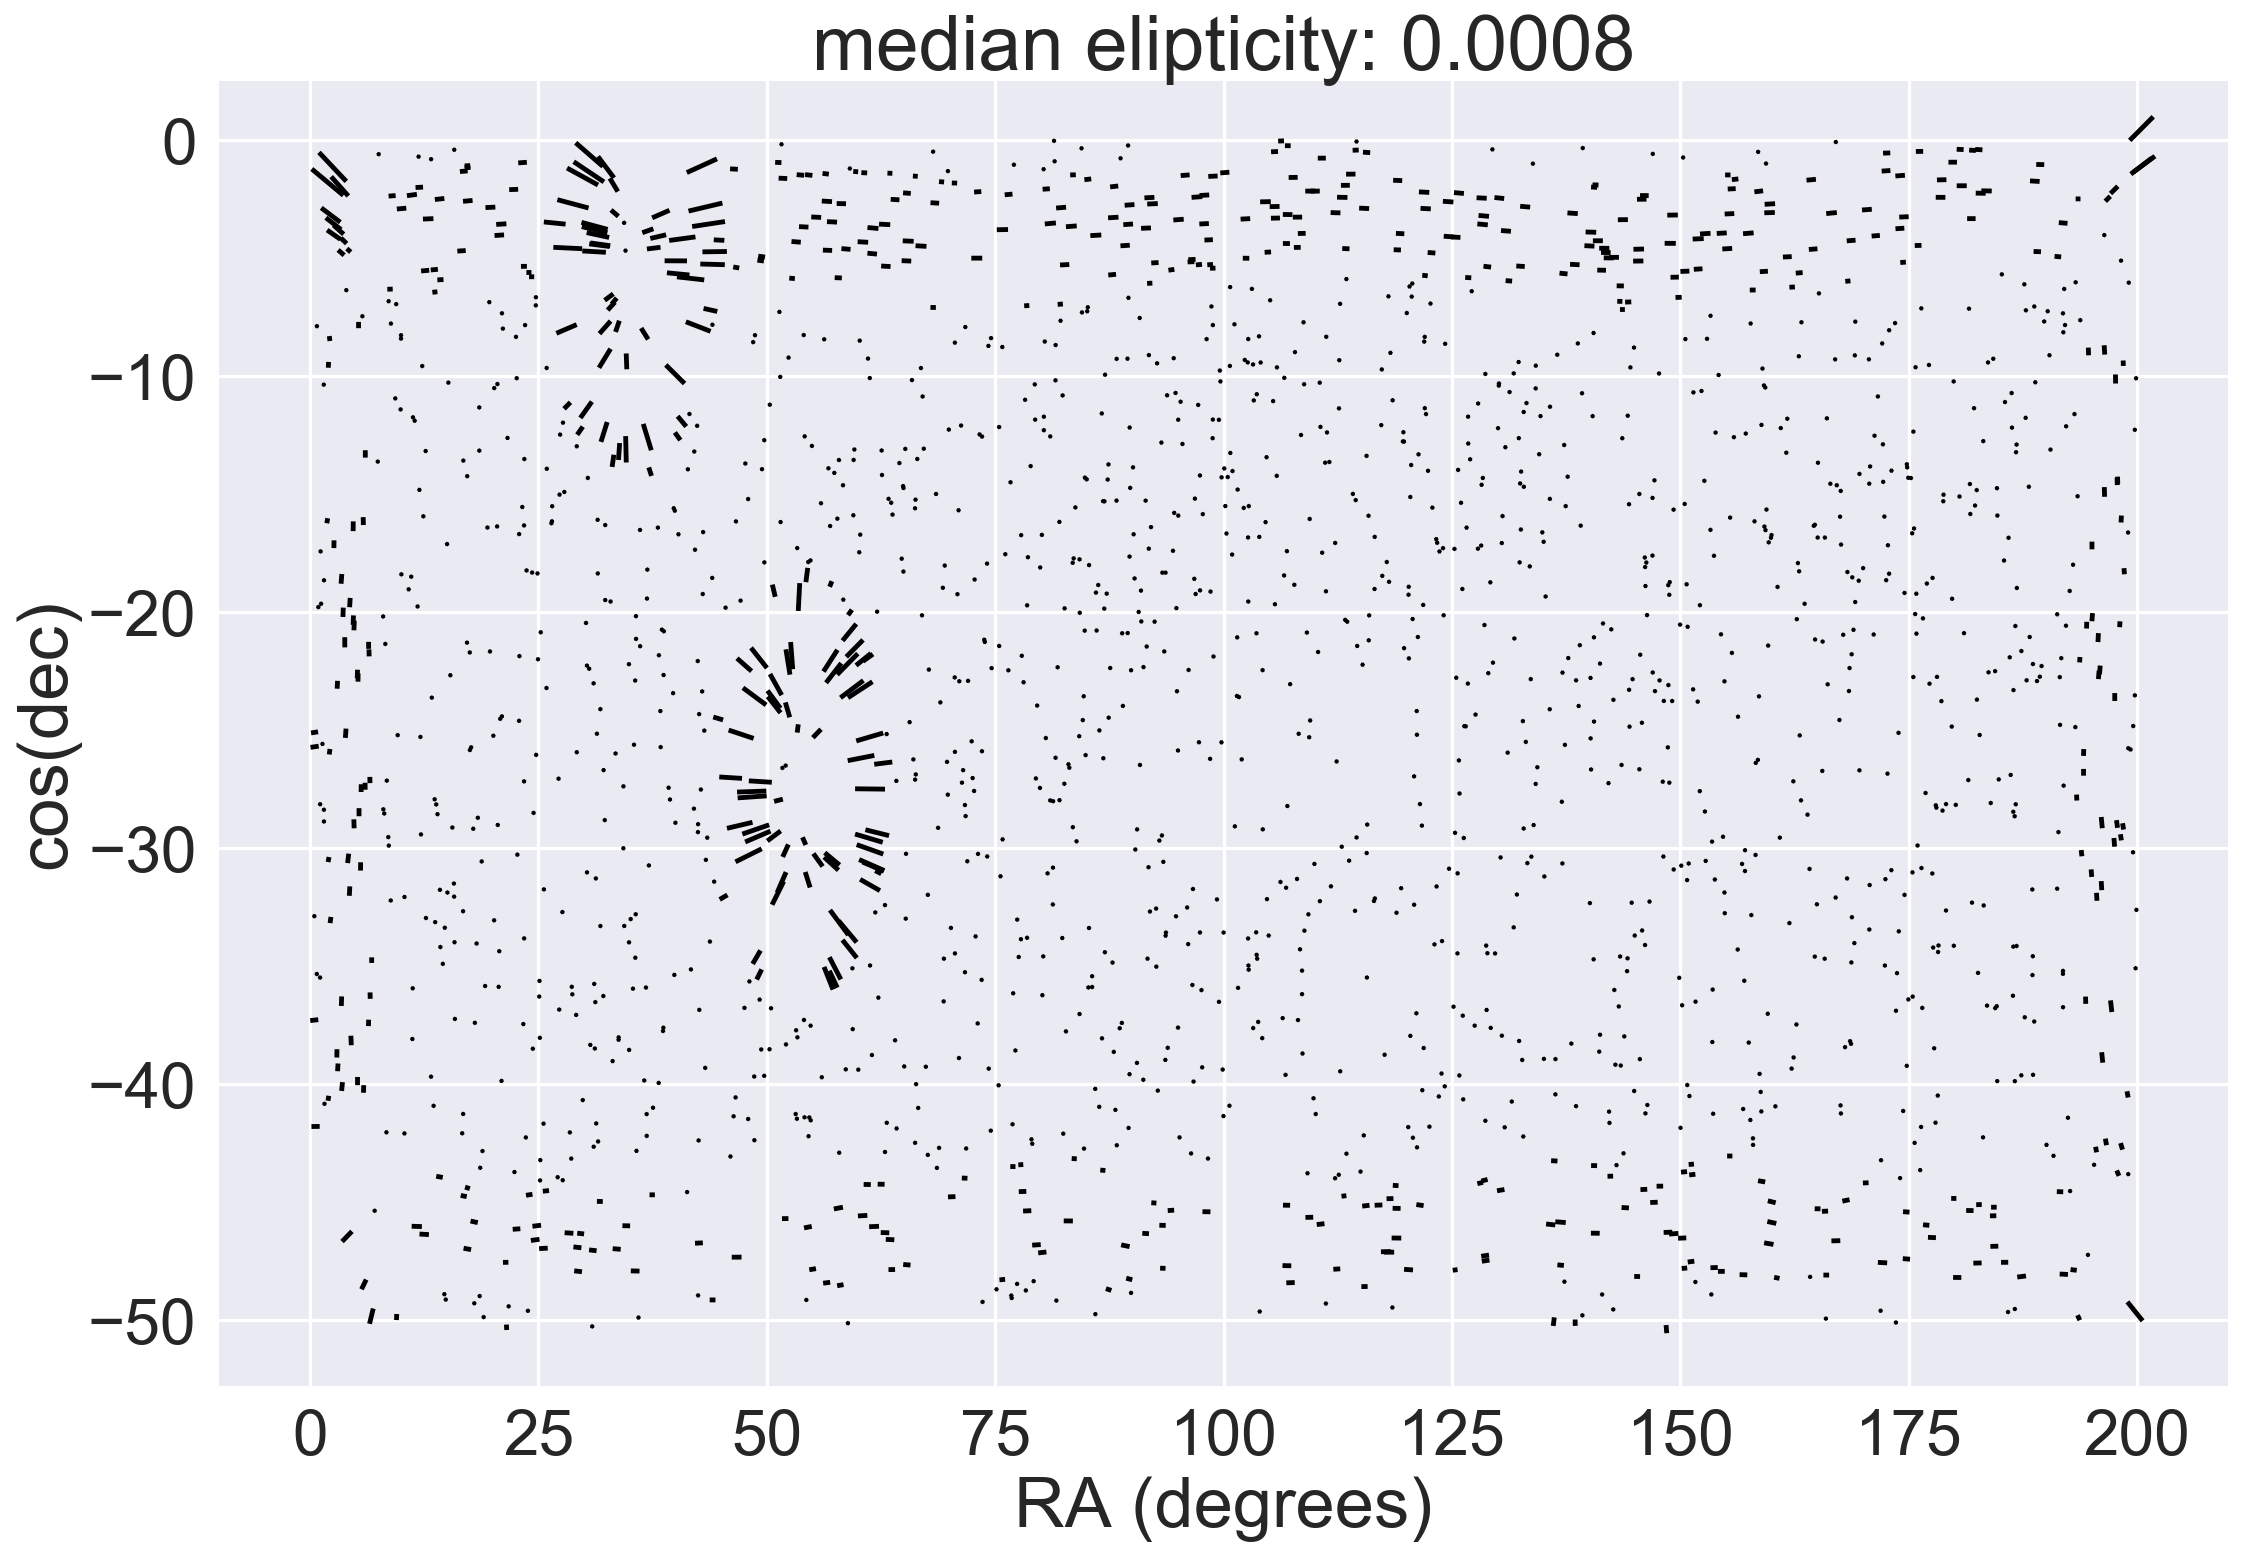

In [96]:
sns.set_context('poster',font_scale=2)


X = np.array(best_case.PSF.e.keys())[:,0]
Y = np.array(best_case.PSF.e.keys())[:,1]
e1 = np.array(best_case.PSF.e.values())[:,0]
e2 = np.array(best_case.PSF.e.values())[:,1]
angles = np.zeros(len(X))
U = np.sqrt(e1**2+e2**2)
for i in range(len(U)):
    angles[i] = r2d(0.5*np.arctan2(e2[i],e1[i]))
pixel_scale = r2d(1)
V = np.zeros(np.shape(U))
print np.median(U)
Q = plt.quiver(pixel_scale*X,Y*pixel_scale,U,V,angles=angles,
               headlength=0,headaxislength=0,scale=1,units='height');
plt.xlabel('RA (degrees)')
plt.ylabel('cos(dec)')
plt.title(r'median elipticity: {:.4f}'.format(np.median(U)))

#qk = plt.quiverkey(Q, 0.8, 0.85, 0.005, r'$|e|=0.01$', labelpos='E', coordinates='figure')

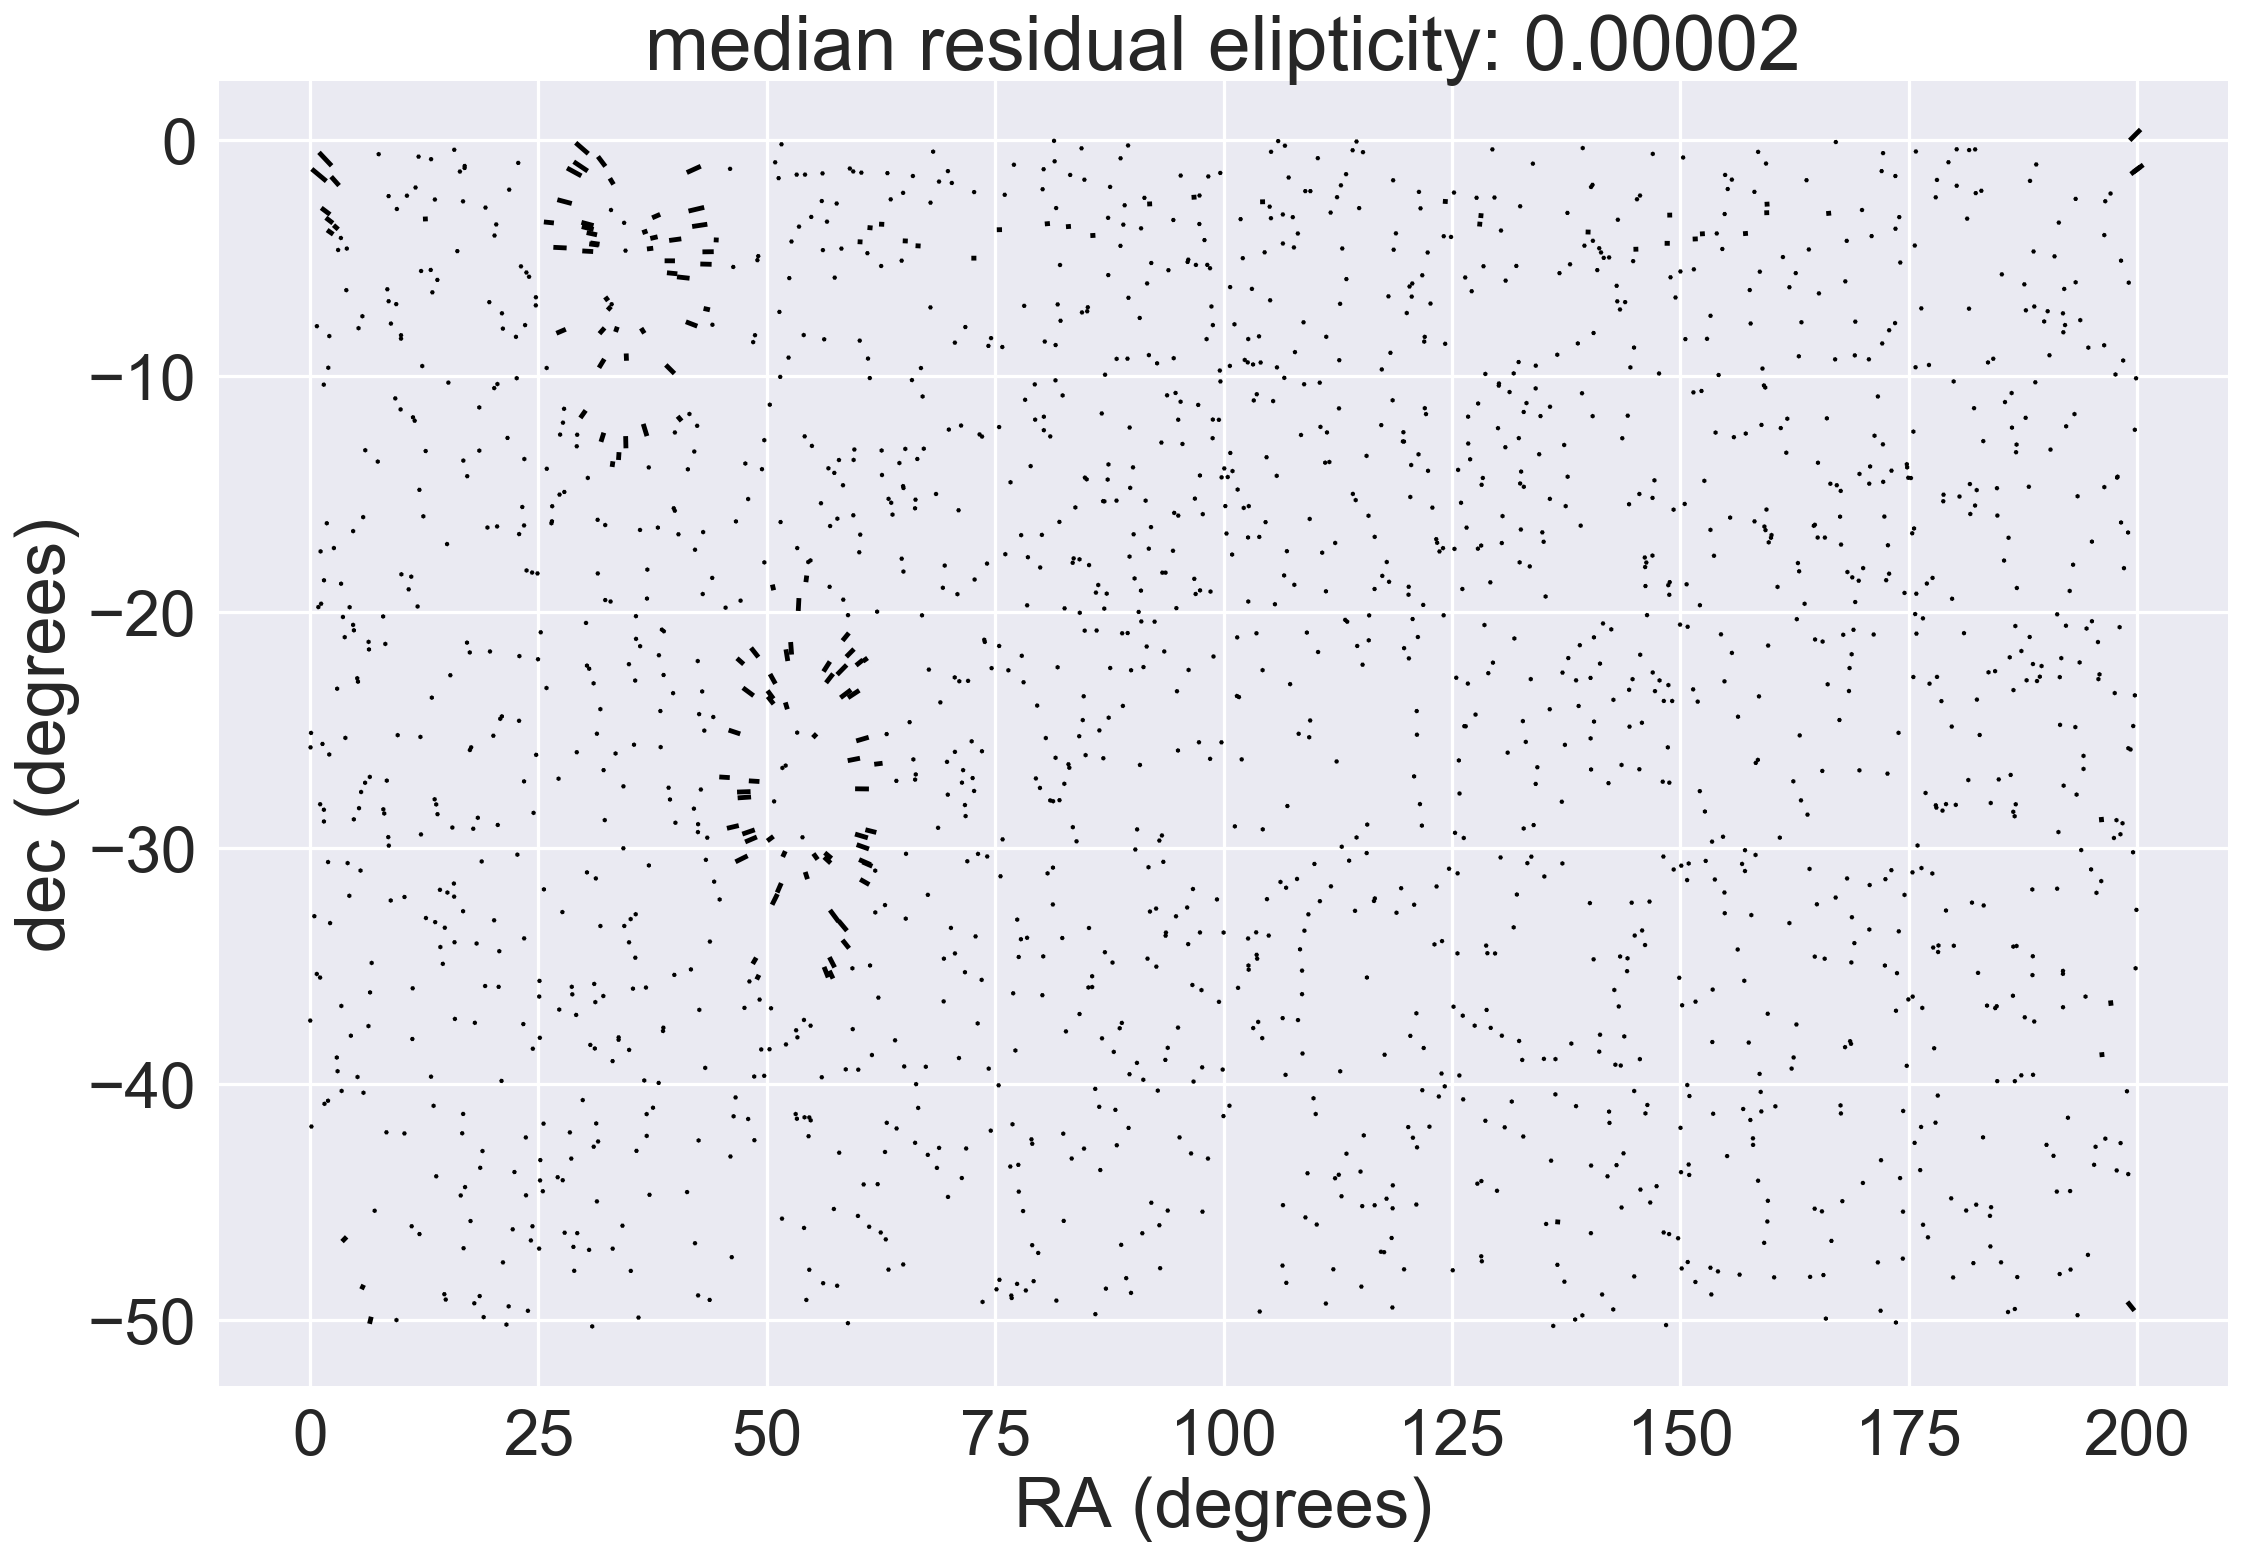

In [97]:
X = np.array(best_case.DELTA.e.keys())[:,0]
Y = np.array(best_case.DELTA.e.keys())[:,1]
e1 = np.array(best_case.DELTA.e.values())[:,0]
e2 = np.array(best_case.DELTA.e.values())[:,1]
angles = np.zeros(len(X))
U = np.sqrt(e1**2+e2**2)
for i in range(len(U)):
    angles[i] = r2d(0.5*np.arctan2(e2[i],e1[i]))
pixel_scale = r2d(1)
V = np.zeros(np.shape(U))
Q = plt.quiver(pixel_scale*X,Y*pixel_scale,U,V,angles=angles,
               headlength=0,headaxislength=0,scale=1/10,cmap='viridis')
plt.xlabel('RA (degrees)')
plt.ylabel('dec (degrees)')
# plt.xlim((-5,250))
# qk = plt.quiverkey(Q, 0.83, 0.75, 0.01, r'$|\Delta e|=0.01$', labelpos='E', coordinates='figure')
plt.title(r'median residual elipticity: {:.5f}'.format(np.median(U)))

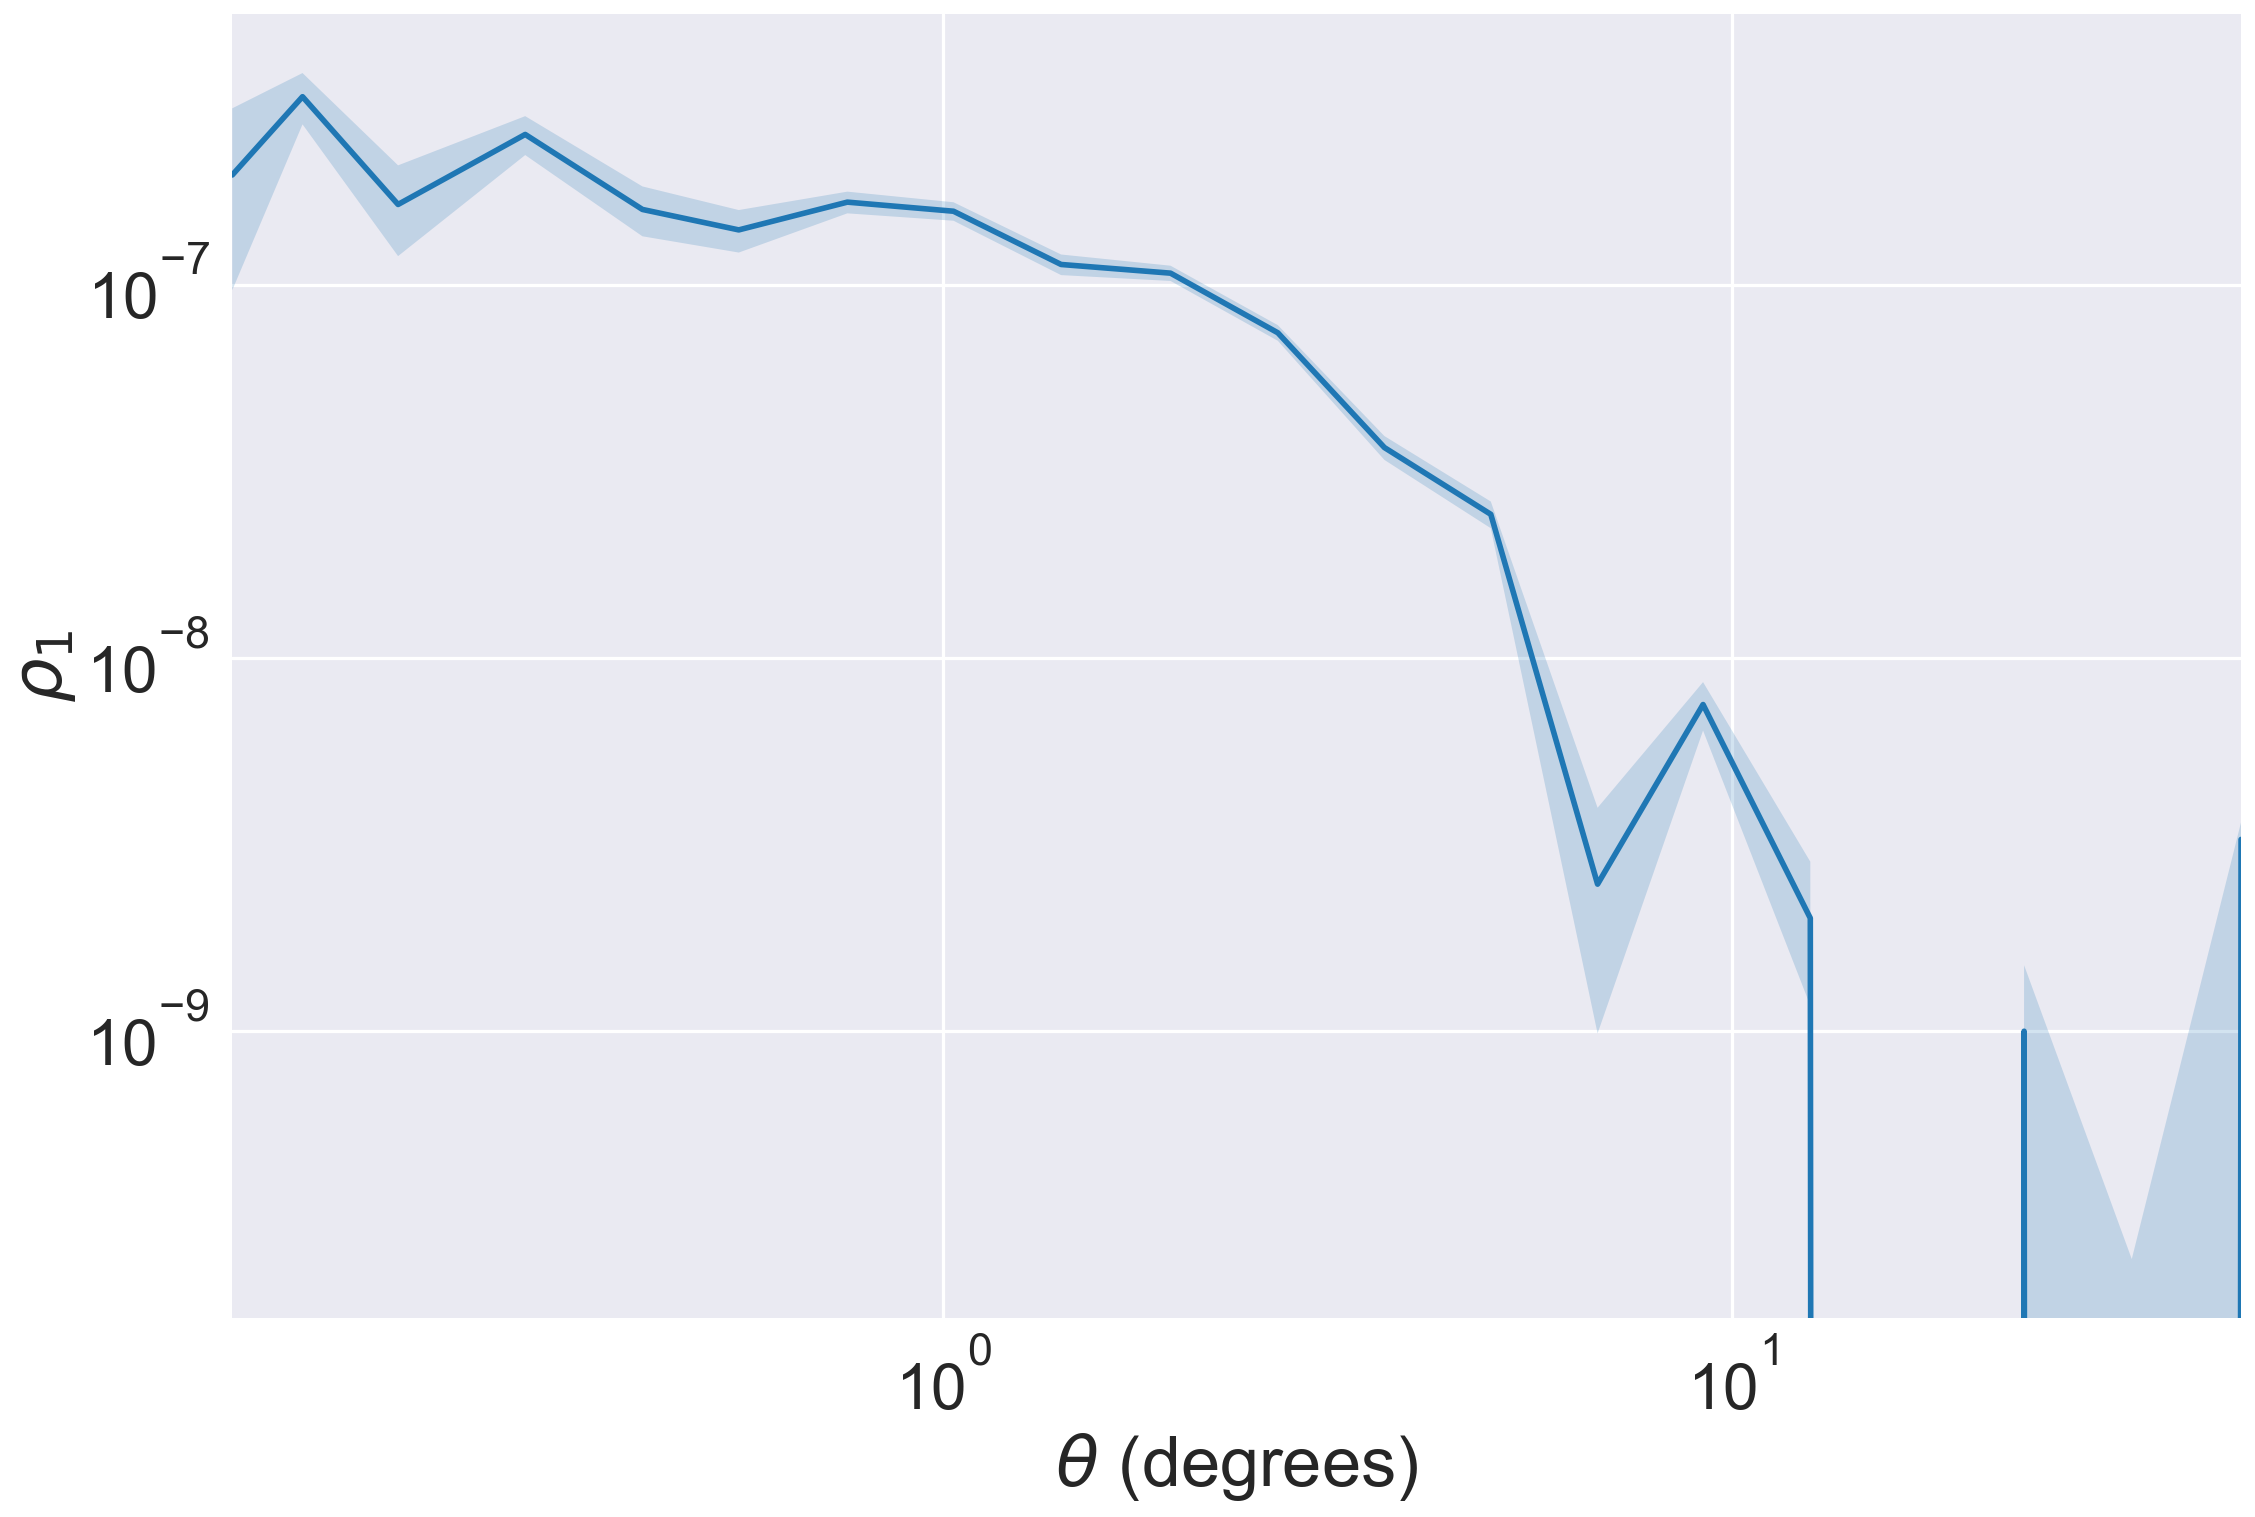

In [57]:
cat = treecorr.Catalog(g1=e1, g2=e2, ra=X, dec=Y,ra_units='radians',dec_units='radians')
gg = treecorr.GGCorrelation(min_sep=0.1, max_sep=50, nbins=20, sep_units='degrees')
gg.process(cat)
xip = gg.xip
xim = gg.xim
sigma = gg.varxi**0.5

def _plot_std_bars(std=None, central_data=None, ci=None, data=None,*args, **kwargs):
    std = sigma
    ci = np.asarray((central_data - std, central_data + std))
    kwargs.update({"central_data": central_data, "ci": ci, "data": data})
    seaborn.timeseries._plot_ci_band(*args, **kwargs)
seaborn.timeseries._plot_std_bars = _plot_std_bars
r = np.exp(gg.meanlogr)
sns.tsplot(xip,r,err_style='std_bars')
#sns.tsplot(xim,r,err_style='std_bars',color='r')
plt.xlabel(r'$\theta$ (degrees)')
plt.ylabel(r'$\rho_1$')
plt.xscale('log')
plt.yscale('log')
#plt.yscale('symlog')
#plt.ylim(-1E-5, 1.5E-5)
#plt.legend([r'$\xi_+$',r'$\xi_-$'],bbox_to_anchor=(0.98, 1), loc='upper right', borderaxespad=0.)

In [ ]:
# make star e about 0.05
# typical size of residual about 0.005 (noise),  systematic error ~3%

In [65]:
# 2 kinds of plots, one with rhos for y1 and one for y10, and one for both years for the same statisticsx

In [ ]:
def _plot_std_bars(std=None, central_data=None, ci=None, data=None,*args, **kwargs):
    std = best_case.rho2_sigma
    ci = np.asarray((central_data - std, central_data + std))
    kwargs.update({"central_data": central_data, "ci": ci, "data": data})
    seaborn.timeseries._plot_ci_band(*args, **kwargs)
seaborn.timeseries._plot_std_bars = _plot_std_bars
#sns.tsplot(best_case.rho1,best_case.r)#,err_style='std_bars')
sns.tsplot(best_case.rho2,best_case.r,err_style='ci_band',color='r')#,err_style='std_bars')
plt.xlabel(r'$\theta$ (degrees)')
plt.ylabel(r'$\xi$')
plt.xscale('log')
plt.yscale('symlog')
plt.legend([r'$\rho_1$',r'$\rho_2$'],bbox_to_anchor=(0.98, 1), loc='upper right', borderaxespad=0.)

In [137]:
y1 = ModelErrors('radial',WorstCase=False)

In [138]:
y1.process(sqlWhere='filter = "r" and night < 365 and fieldRA < %f and fieldDec > %f and fieldRA > 0 and fieldDec < 0' % (np.radians(200), np.radians(-50)))

number of stars dither positions:  11422


TypeError: unsupported operand type(s) for *: 'Catalog' and 'float'

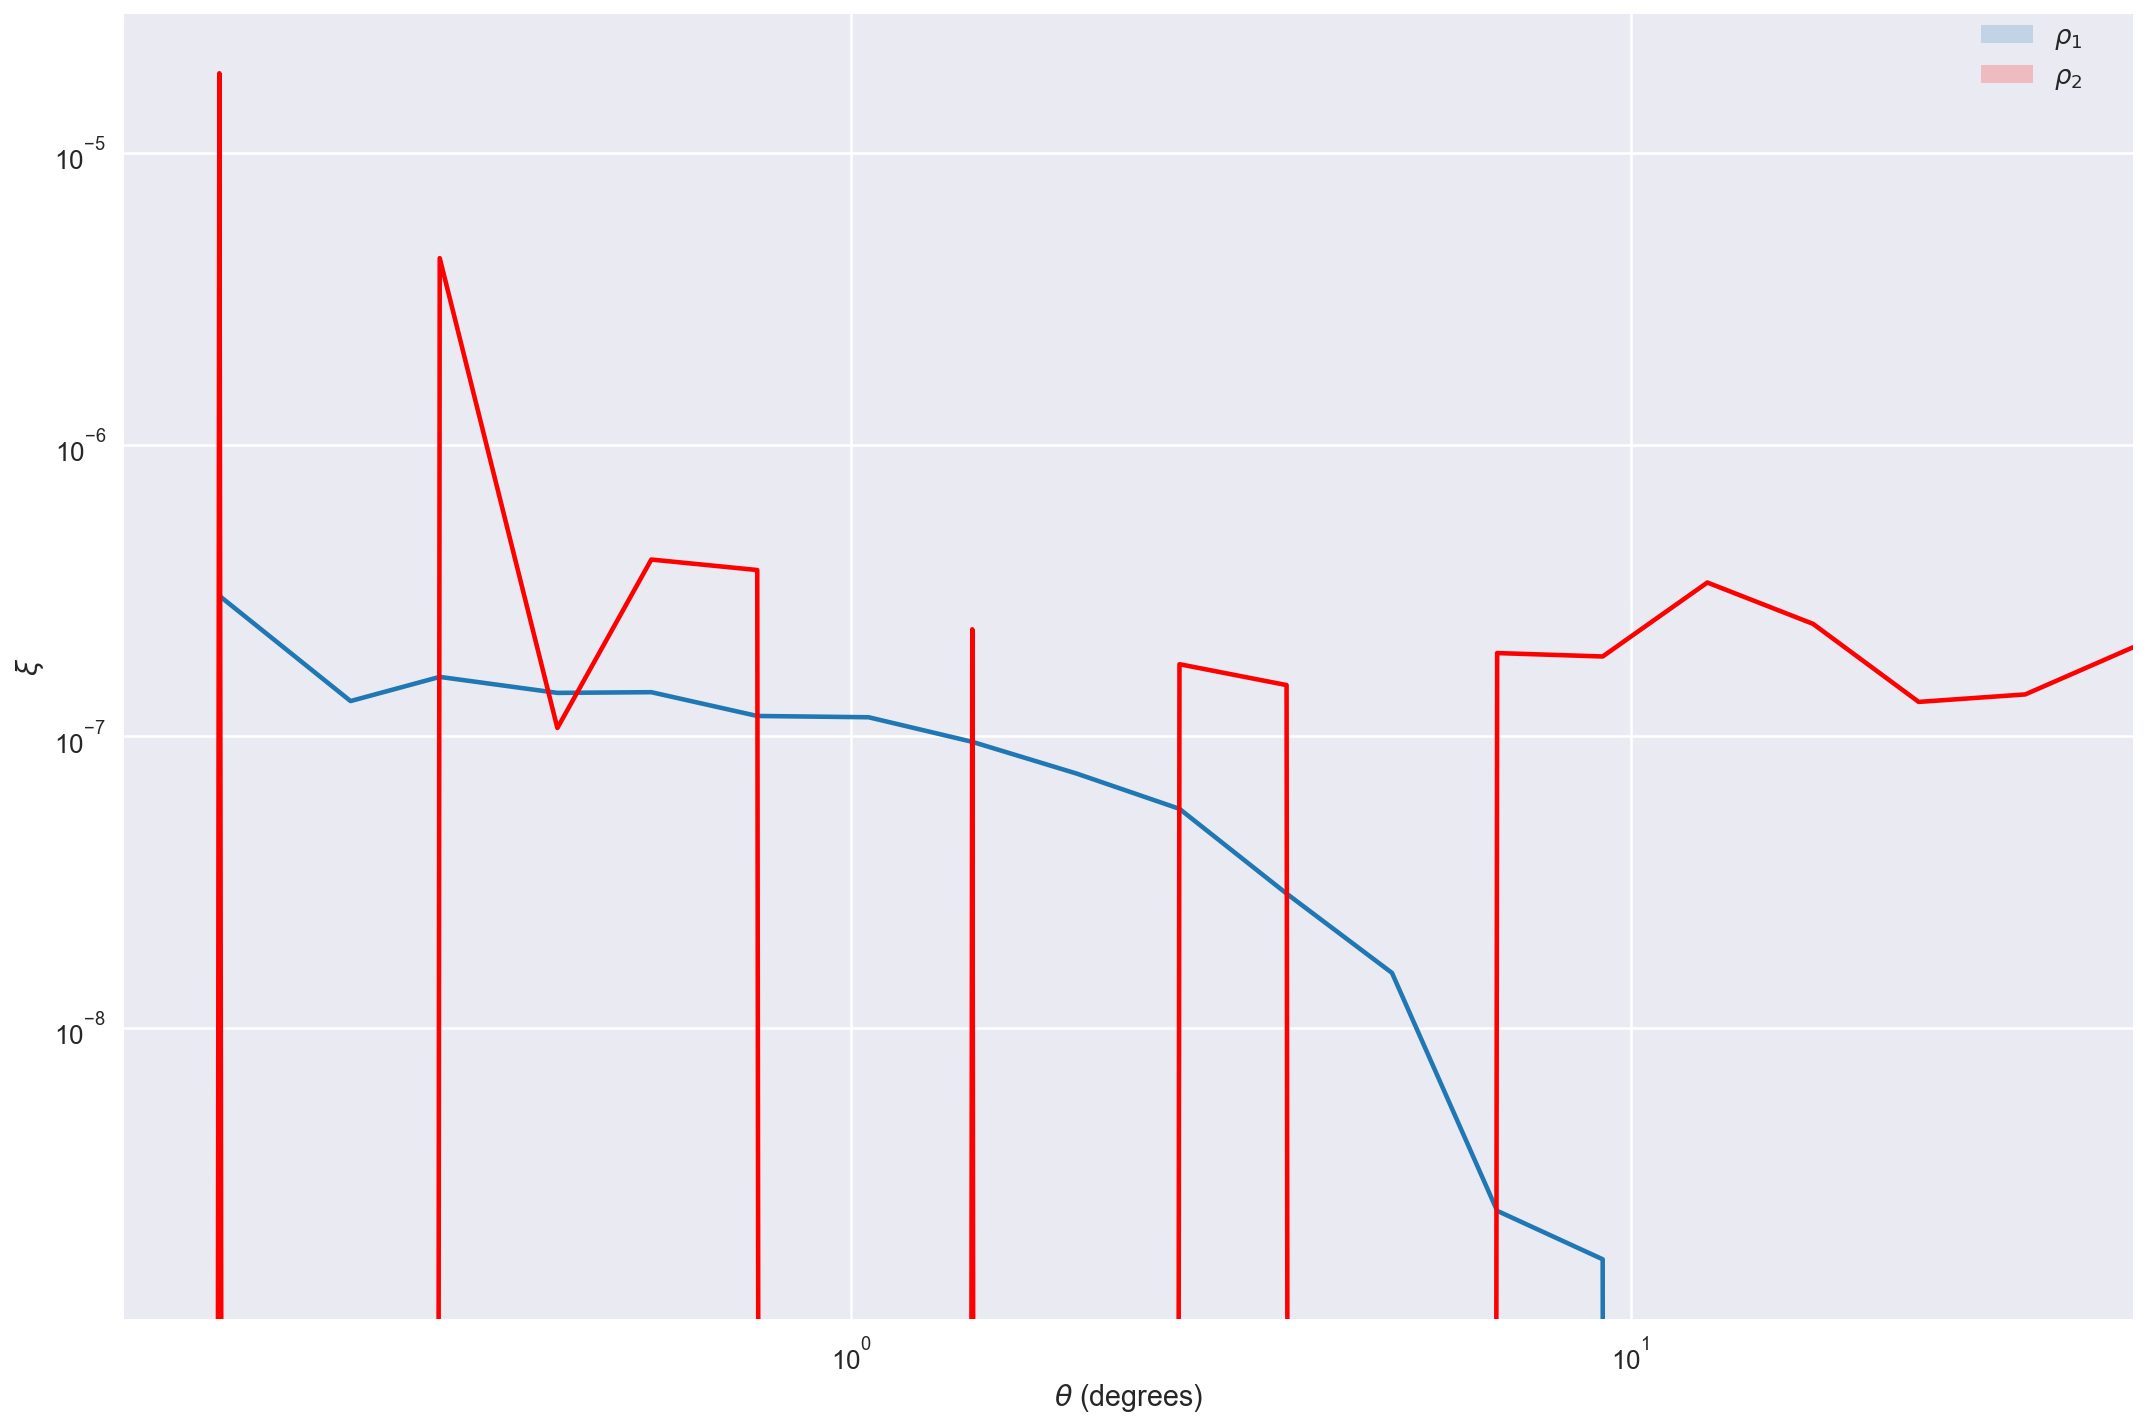

In [139]:
seaborn.timeseries._plot_std_bars = _plot_std_bars
sns.tsplot(y1.rho1,y1.r)#,err_style='std_bars')
sns.tsplot(y1.rho2,y1.r,color='r')#,err_style='std_bars')
plt.xlabel(r'$\theta$ (degrees)')
plt.ylabel(r'$\xi$')
plt.xscale('log')
plt.yscale('log')
plt.legend([r'$\rho_1$',r'$\rho_2$'],bbox_to_anchor=(0.98, 1), loc='upper right', borderaxespad=0.)

0.000415505696674


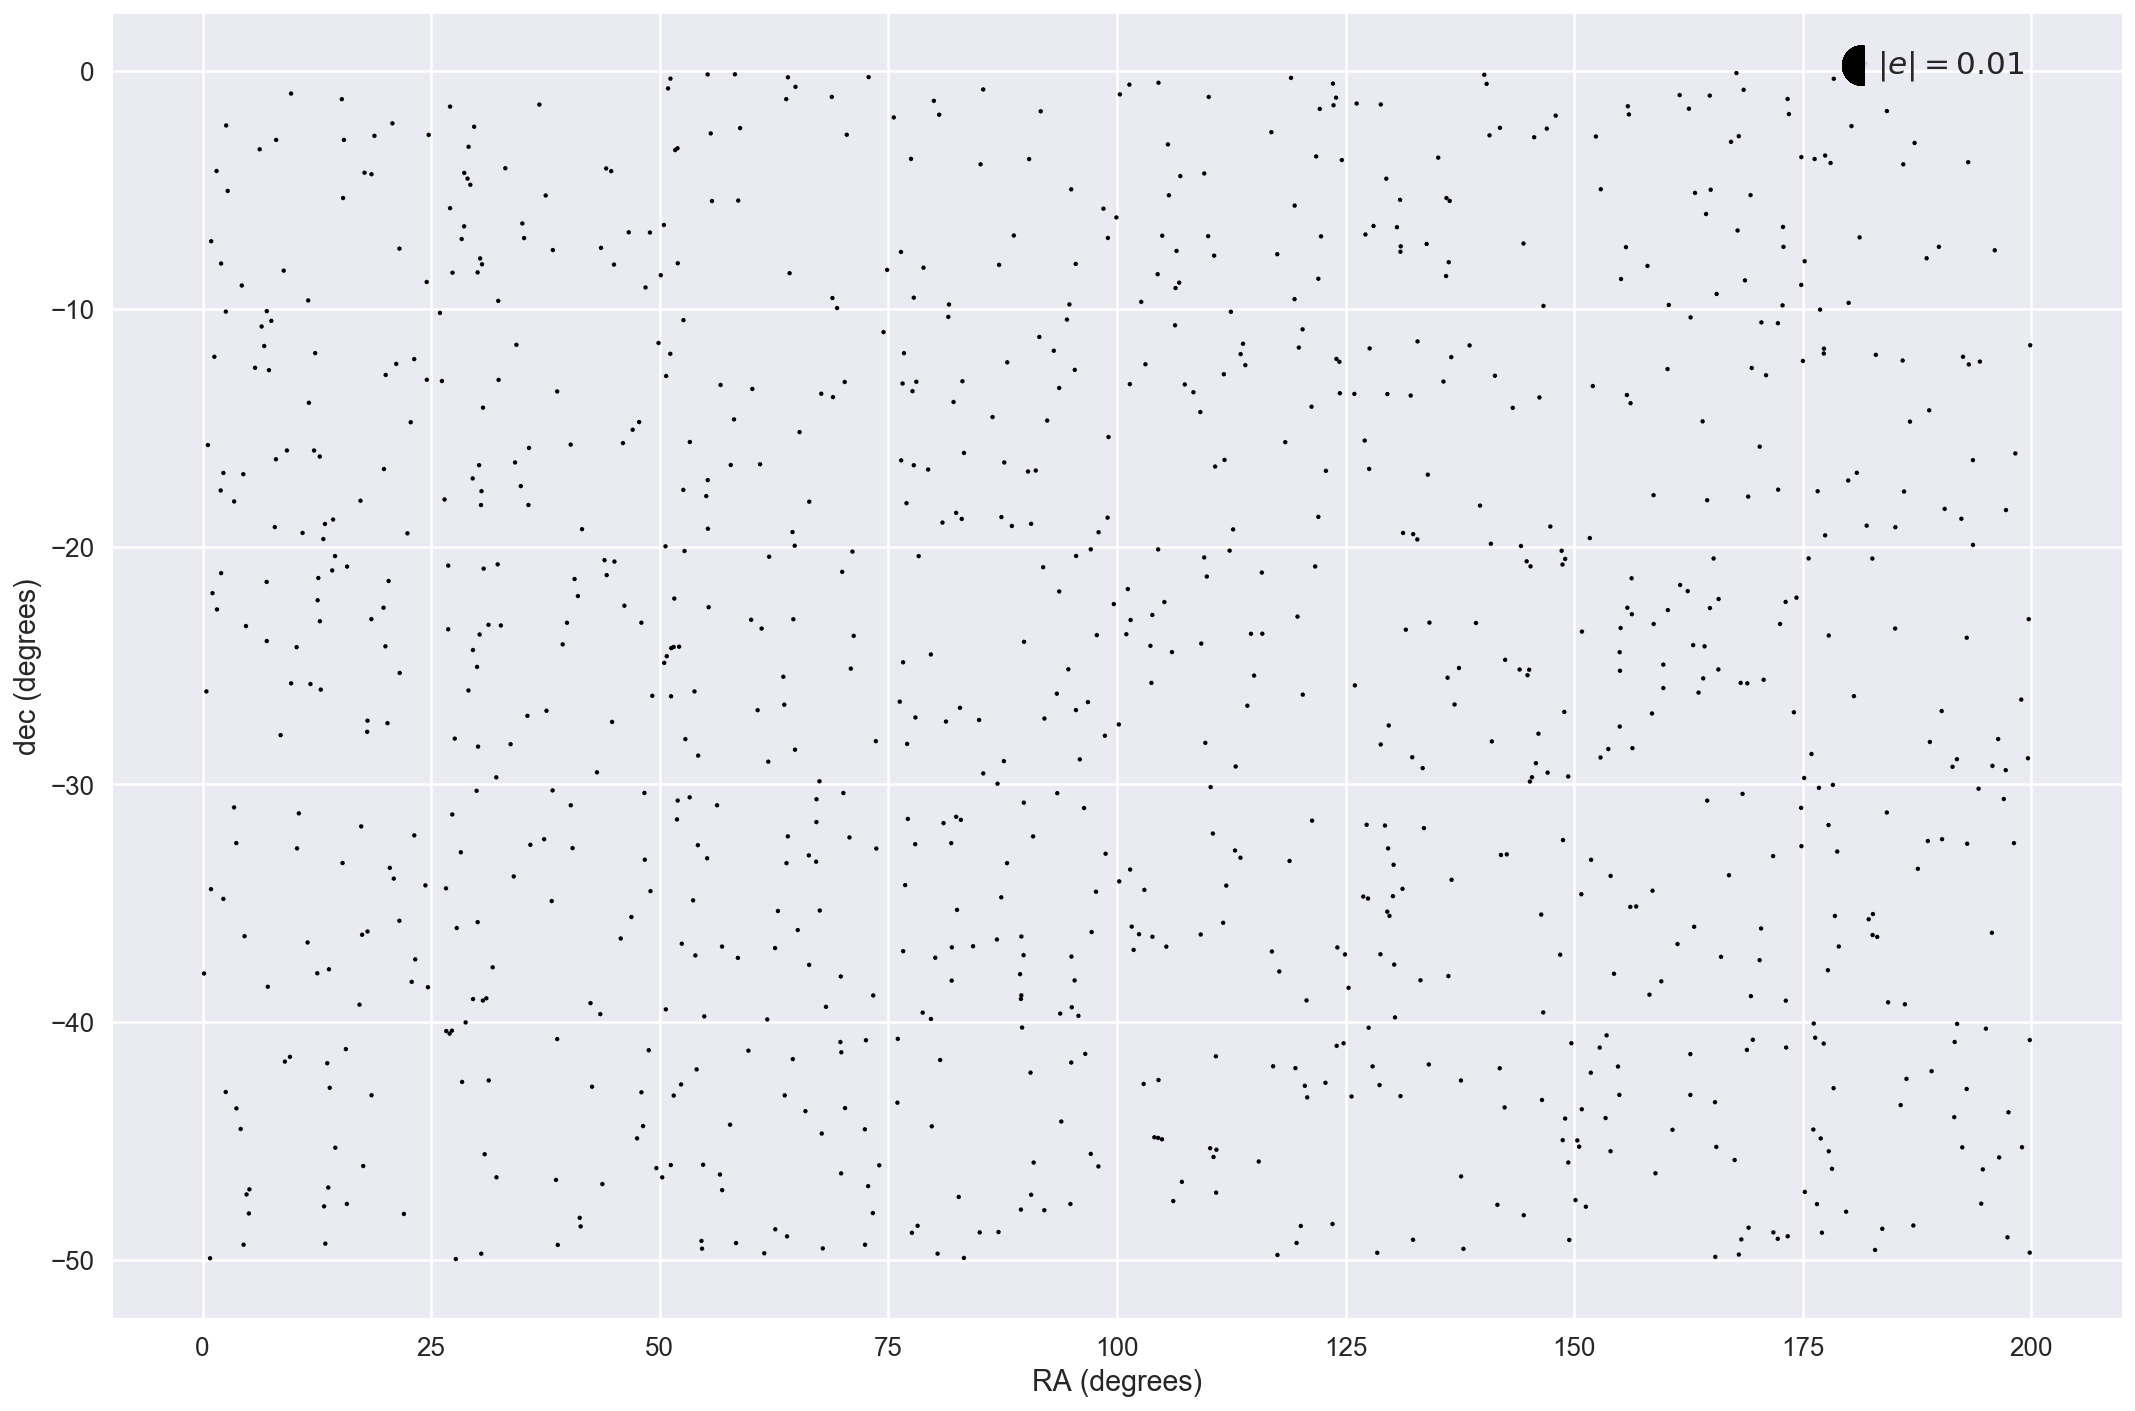

In [188]:
X = np.array(y1.DELTA.e.keys())[:,0]
Y = np.array(y1.DELTA.e.keys())[:,1]
e1 = np.array(y1.DELTA.e.values())[:,0]
e2 = np.array(y1.DELTA.e.values())[:,1]
angles = np.zeros(len(X))
U = np.sqrt(e1**2+e2**2)
for i in range(len(U)):
    angles[i] = r2d(0.5*np.arctan2(e2[i],e1[i]))
pixel_scale = r2d(1)
V = np.zeros(np.shape(U))
Q = plt.quiver(pixel_scale*X,Y*pixel_scale,U,V,angles=angles,
               headlength=0,headaxislength=0,scale=1,cmap='viridis')
plt.xlabel('RA (degrees)')
plt.ylabel('dec (degrees)')
qk = plt.quiverkey(Q, 0.8, 0.85, 0.01, r'$|e|=0.01$', labelpos='E', coordinates='figure')
plt.title(r'median residual elipticity: '+str(np.median(U)))
print np.median(U)

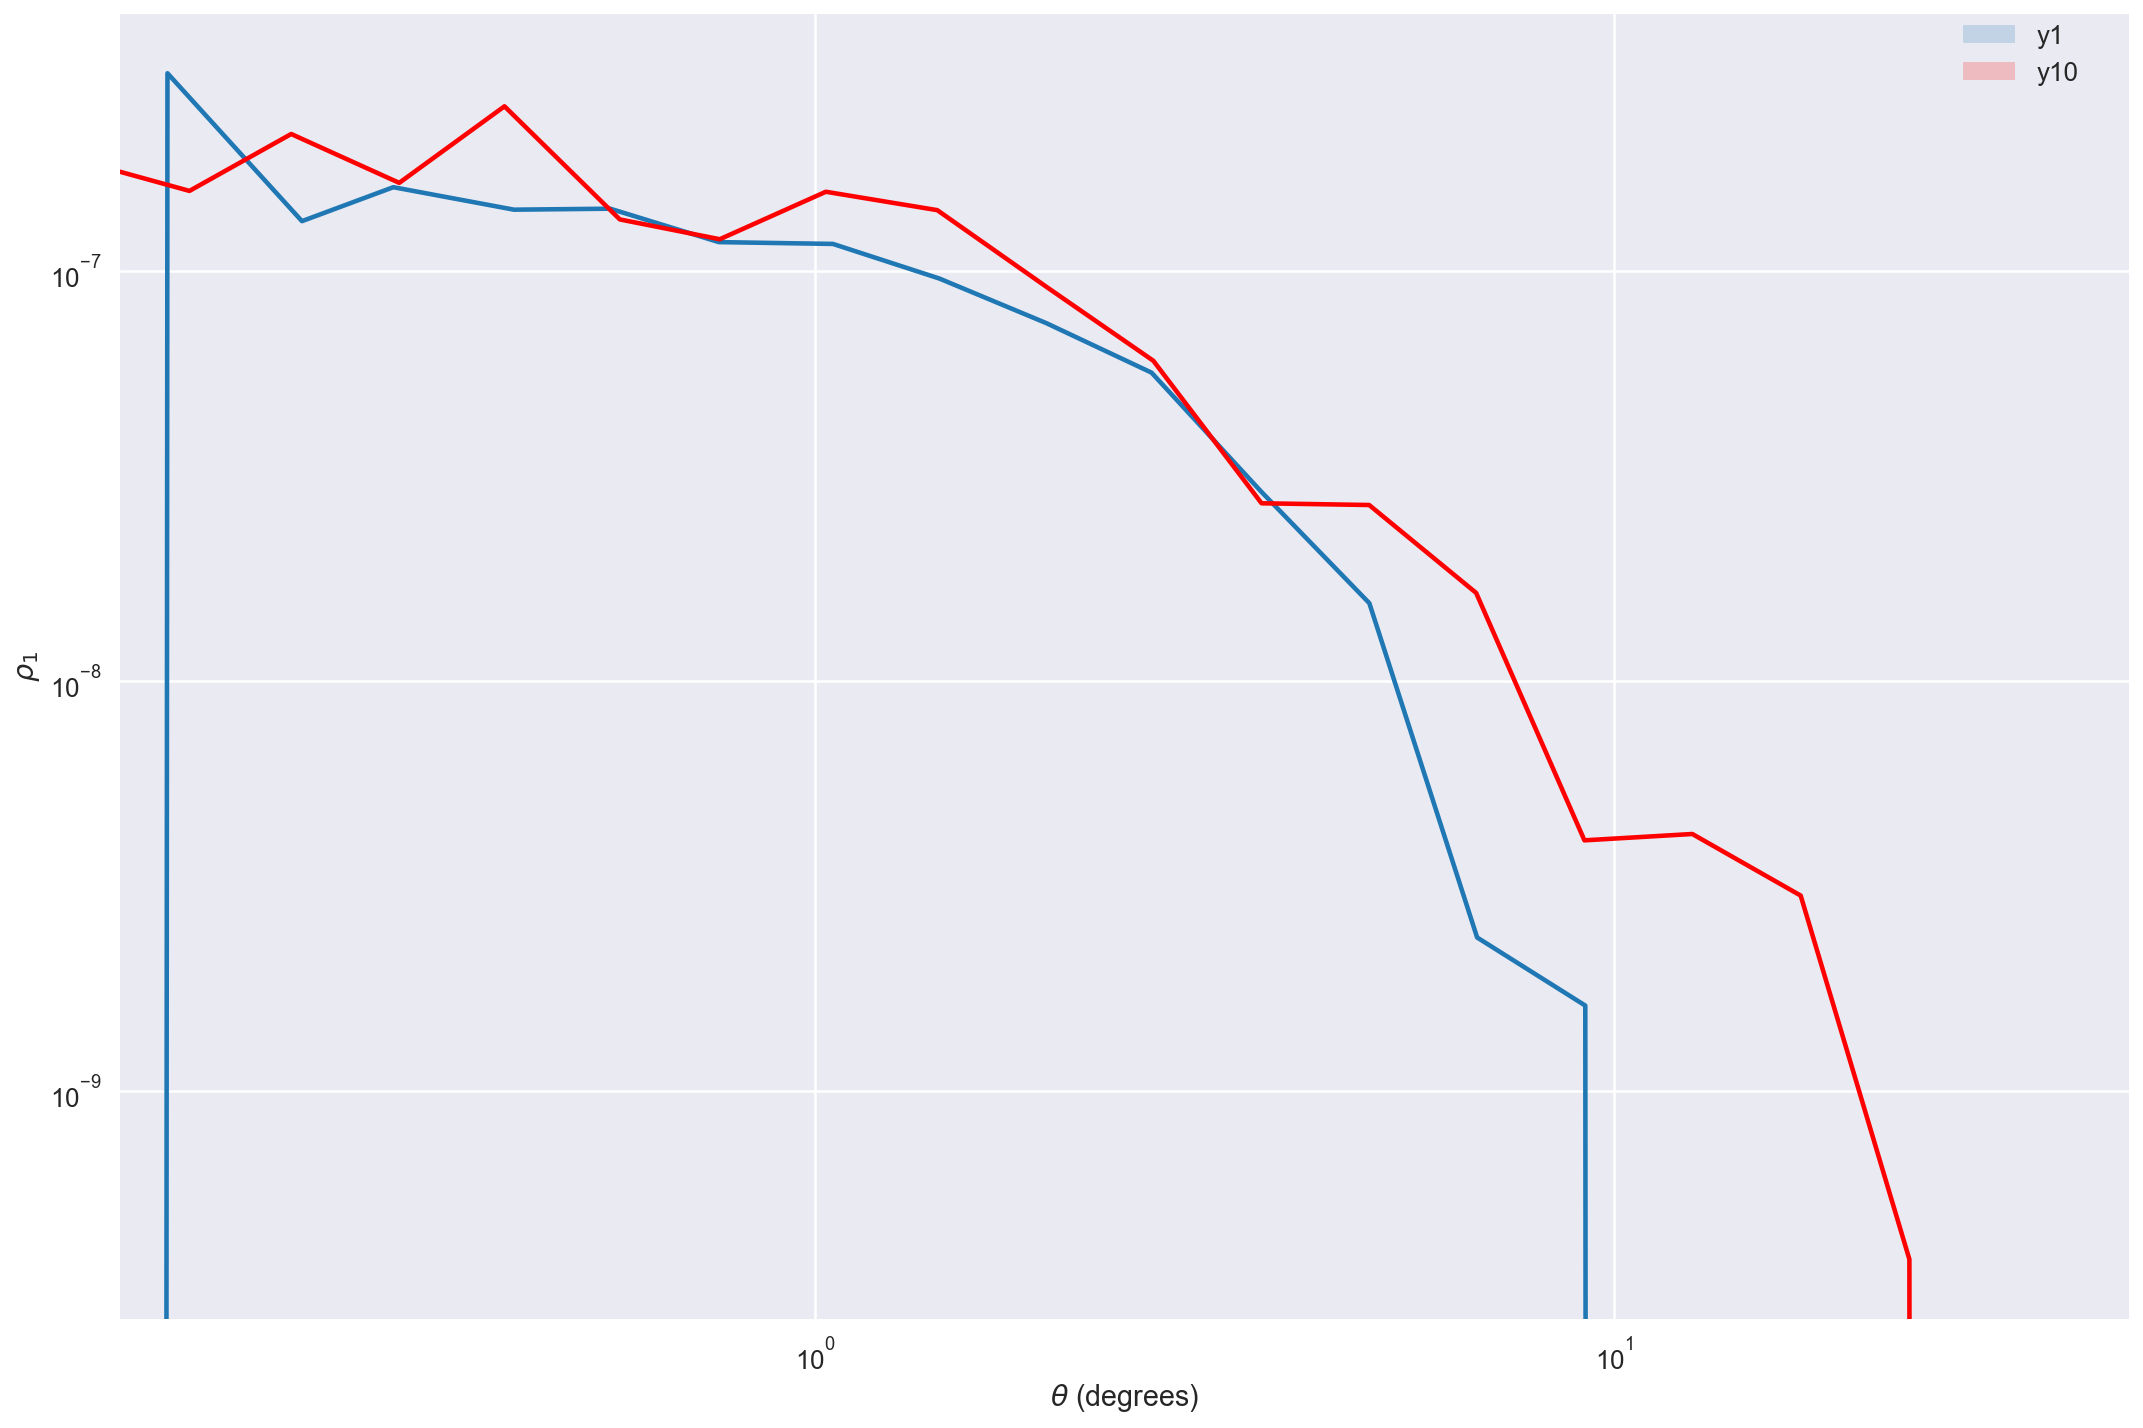

In [142]:
seaborn.timeseries._plot_std_bars = _plot_std_bars
sns.tsplot(y1.rho1,y1.r)#,err_style='std_bars')
sns.tsplot(best_case.rho1,best_case.r,color='r')#,err_style='std_bars')
plt.xlabel(r'$\theta$ (degrees)')
plt.ylabel(r'$\rho_1$')
plt.xscale('log')
plt.yscale('log')
plt.legend([r'y1',r'y10'],bbox_to_anchor=(0.98, 1), loc='upper right', borderaxespad=0.)

231968


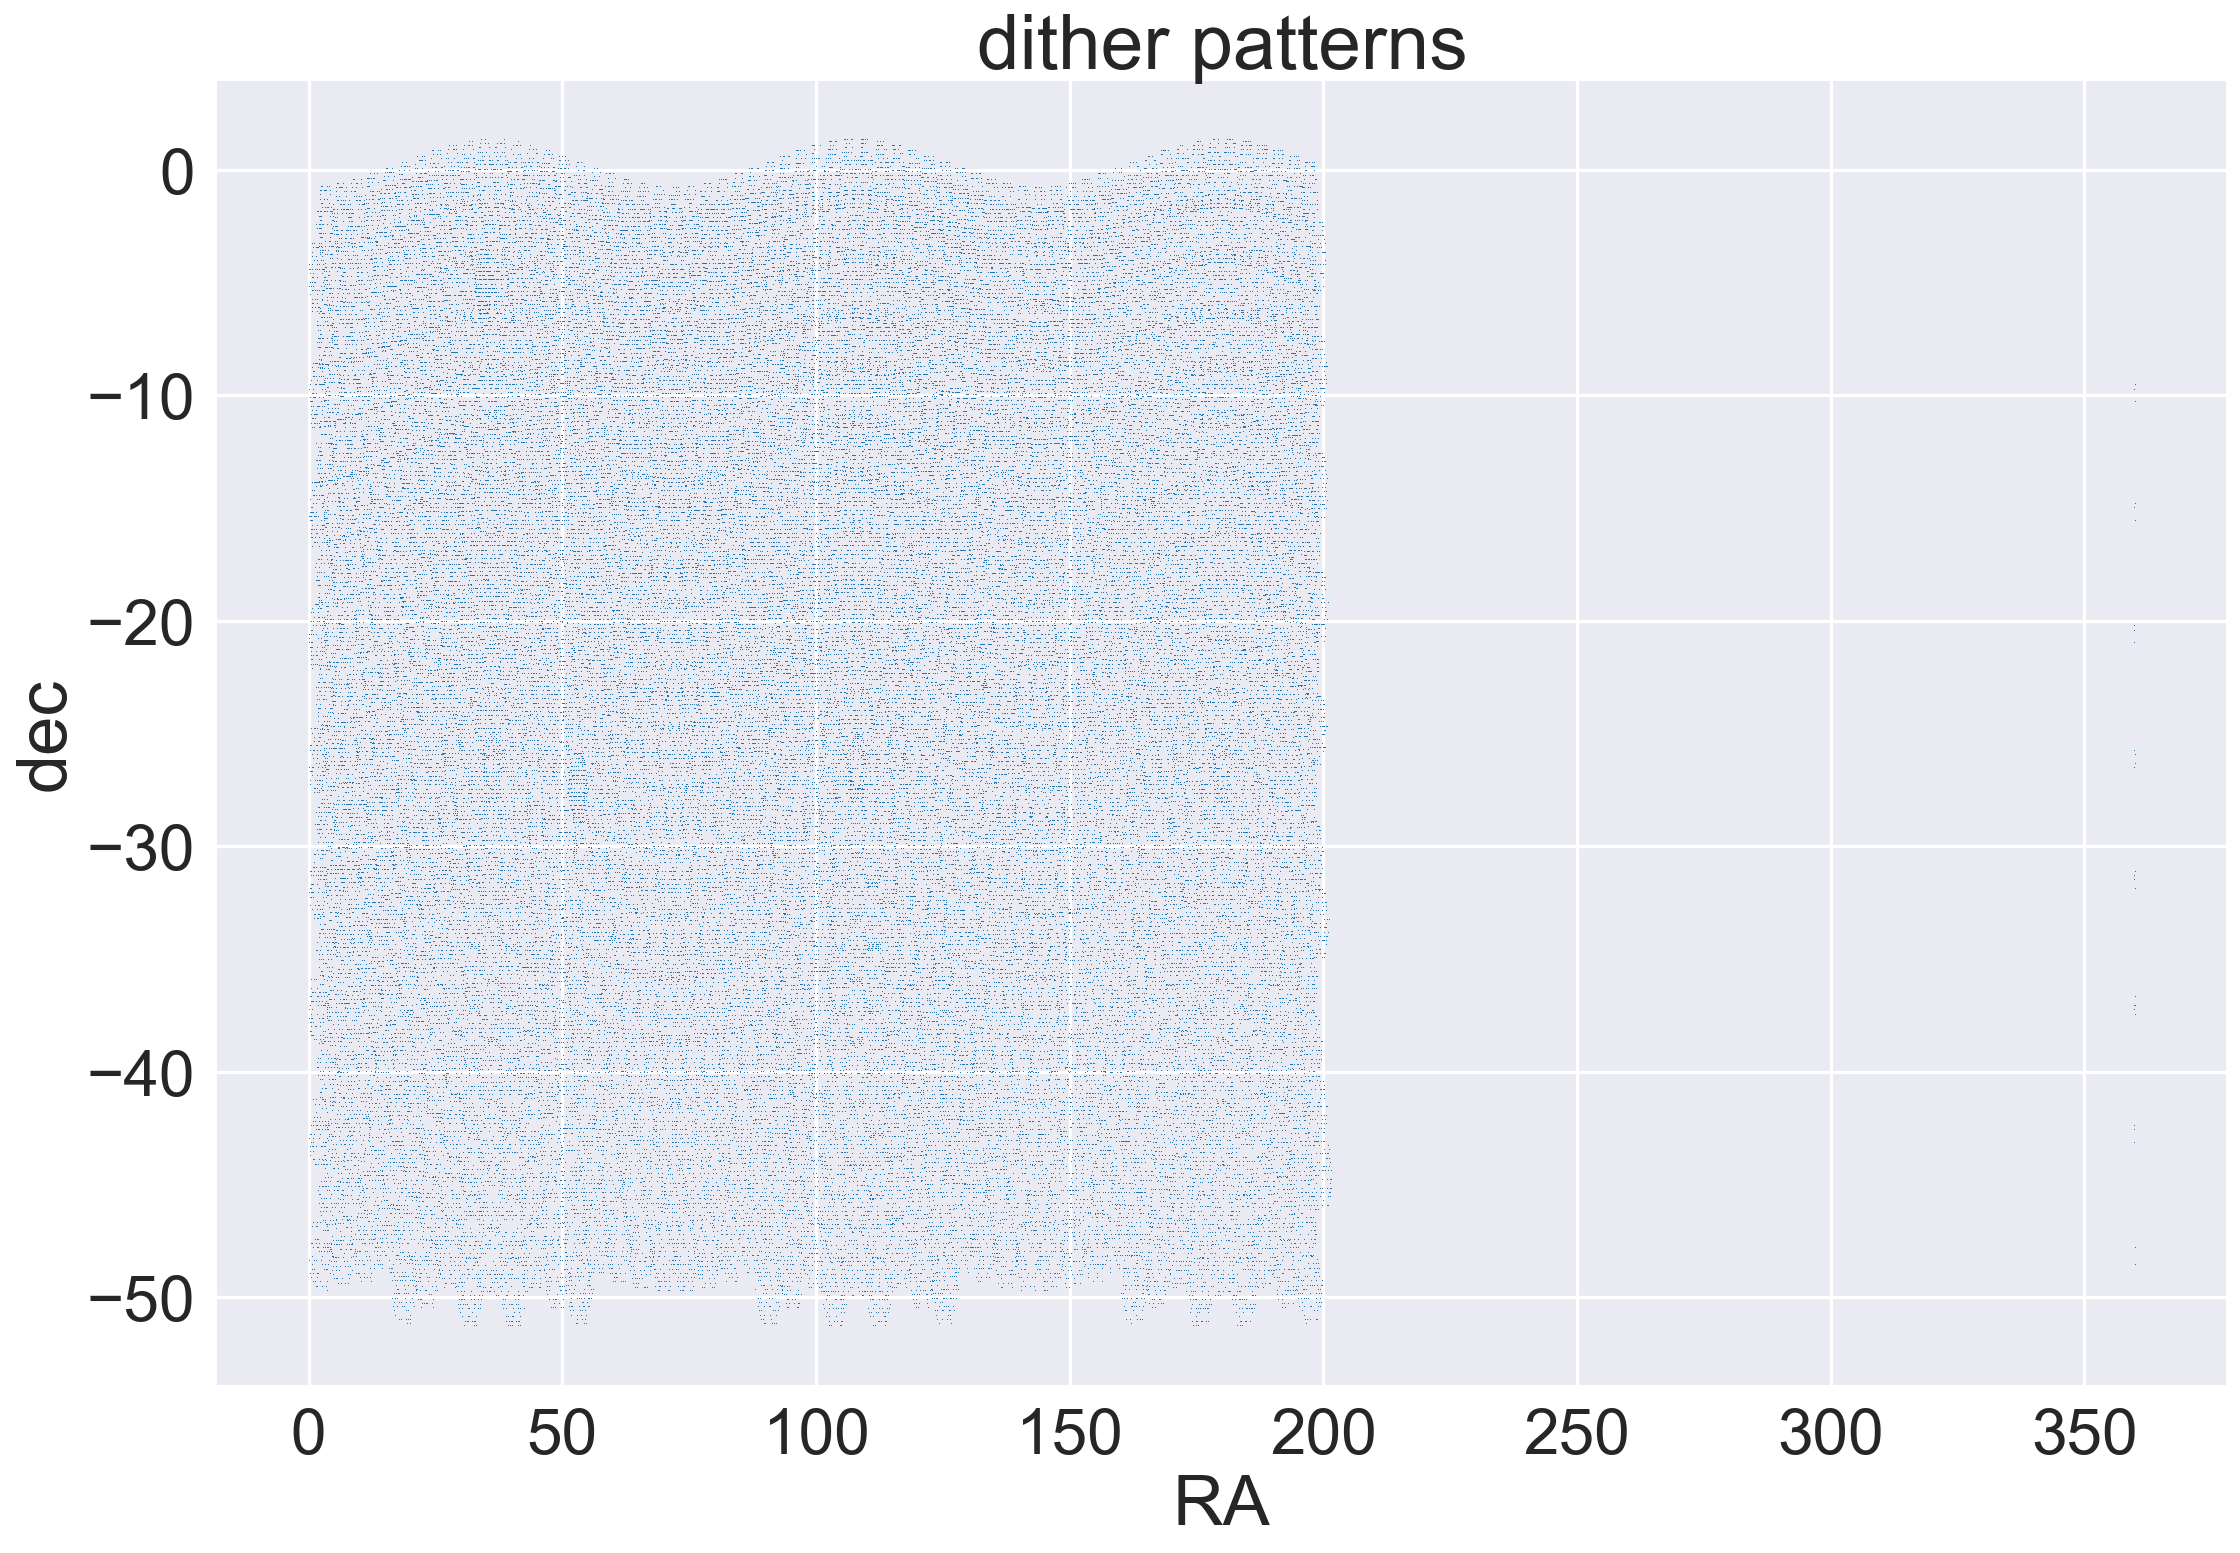

In [38]:
database = '/Users/myhome/Downloads/minion_1016_sqlite.db'
opsdb = db.OpsimDatabase(database)

sqlWhere = 'filter = "r" and night < 40000 and fieldRA < %f and fieldDec > %f and fieldRA > 0 and fieldDec < 0' % (np.radians(200), np.radians(-50))

pos = opsdb.fetchMetricData(('ditheredRA', 'ditheredDec'), sqlconstraint=sqlWhere)
pos = np.array(pos)
if any(row[1] == x for row in pos):
    pos2 = zip(*pos)[1]
if any(row[2] == x for row in pos):
    pos3 = zip(*pos)[2]
pos2,pos3 = np.array(map(lambda x: np.array(x)*180/np.pi,(pos2,pos3)))
plt.plot(pos2,pos3,',')
print len(pos2)
plt.xlabel('RA')
plt.ylabel('dec')
plt.title('dither patterns')

In [191]:
np.random.uniform(1000)

879.2668426476644

In [24]:
worst_case = ModelErrors('radial',True)

In [25]:
worst_case.process(sqlWhere='filter = "r" and night < 40000 and fieldRA < %f and fieldDec > %f and fieldRA > 0 and fieldDec < 0' % (np.radians(200), np.radians(-50)))

number of stars dither positions:  231968


RuntimeError: Catalog has no objects!

In [32]:
worst_case.STAR.e

defaultdict(float,
            {(2.3011388303277878,
              -0.52943970889253822): (-0.027543695162821874, 0.023060715447020756),
             (3.2290158127120492,
              -0.78185716409668471): (-0.049962652346167133, 0.014603757678415565),
             (1.7881709608917558,
              -0.18186200923722162): (-0.019832352676646684, 0.055727327980827253),
             (1.2815380593096286,
              -0.46000072017897708): (-0.014361908684273459, 0.065949264395581644),
             (0.15784801799148787,
              -0.57875632210879968): (0.055694655196740023, -0.045680713851649034),
             (0.0057163061089651225,
              -0.15602824186875131): (-0.013215741973268741, 0.060624191023109911),
             (0.46897981928917015, -0.5260446567685344): (0.044165855916866482,
              -0.025299102622631107),
             (0.77211359660538326,
              -0.54849502921714088): (0.058216120899814053, 0.041120481345983603),
             (3.0927743594218113,

In [33]:
X = np.array(worst_case.STAR.e.keys())[:,0]
Y = np.array(worst_case.STAR.e.keys())[:,1]
e1 = np.array(worst_case.STAR.e.values())[:,0]
e2 = np.array(worst_case.STAR.e.values())[:,1]
angles = np.zeros(len(X))
U = np.sqrt(e1**2+e2**2)
for i in range(len(U)):
    angles[i] = r2d(0.5*np.arctan2(e2[i],e1[i]))
pixel_scale = r2d(1)
V = np.zeros(np.shape(U))

0.0600806532741


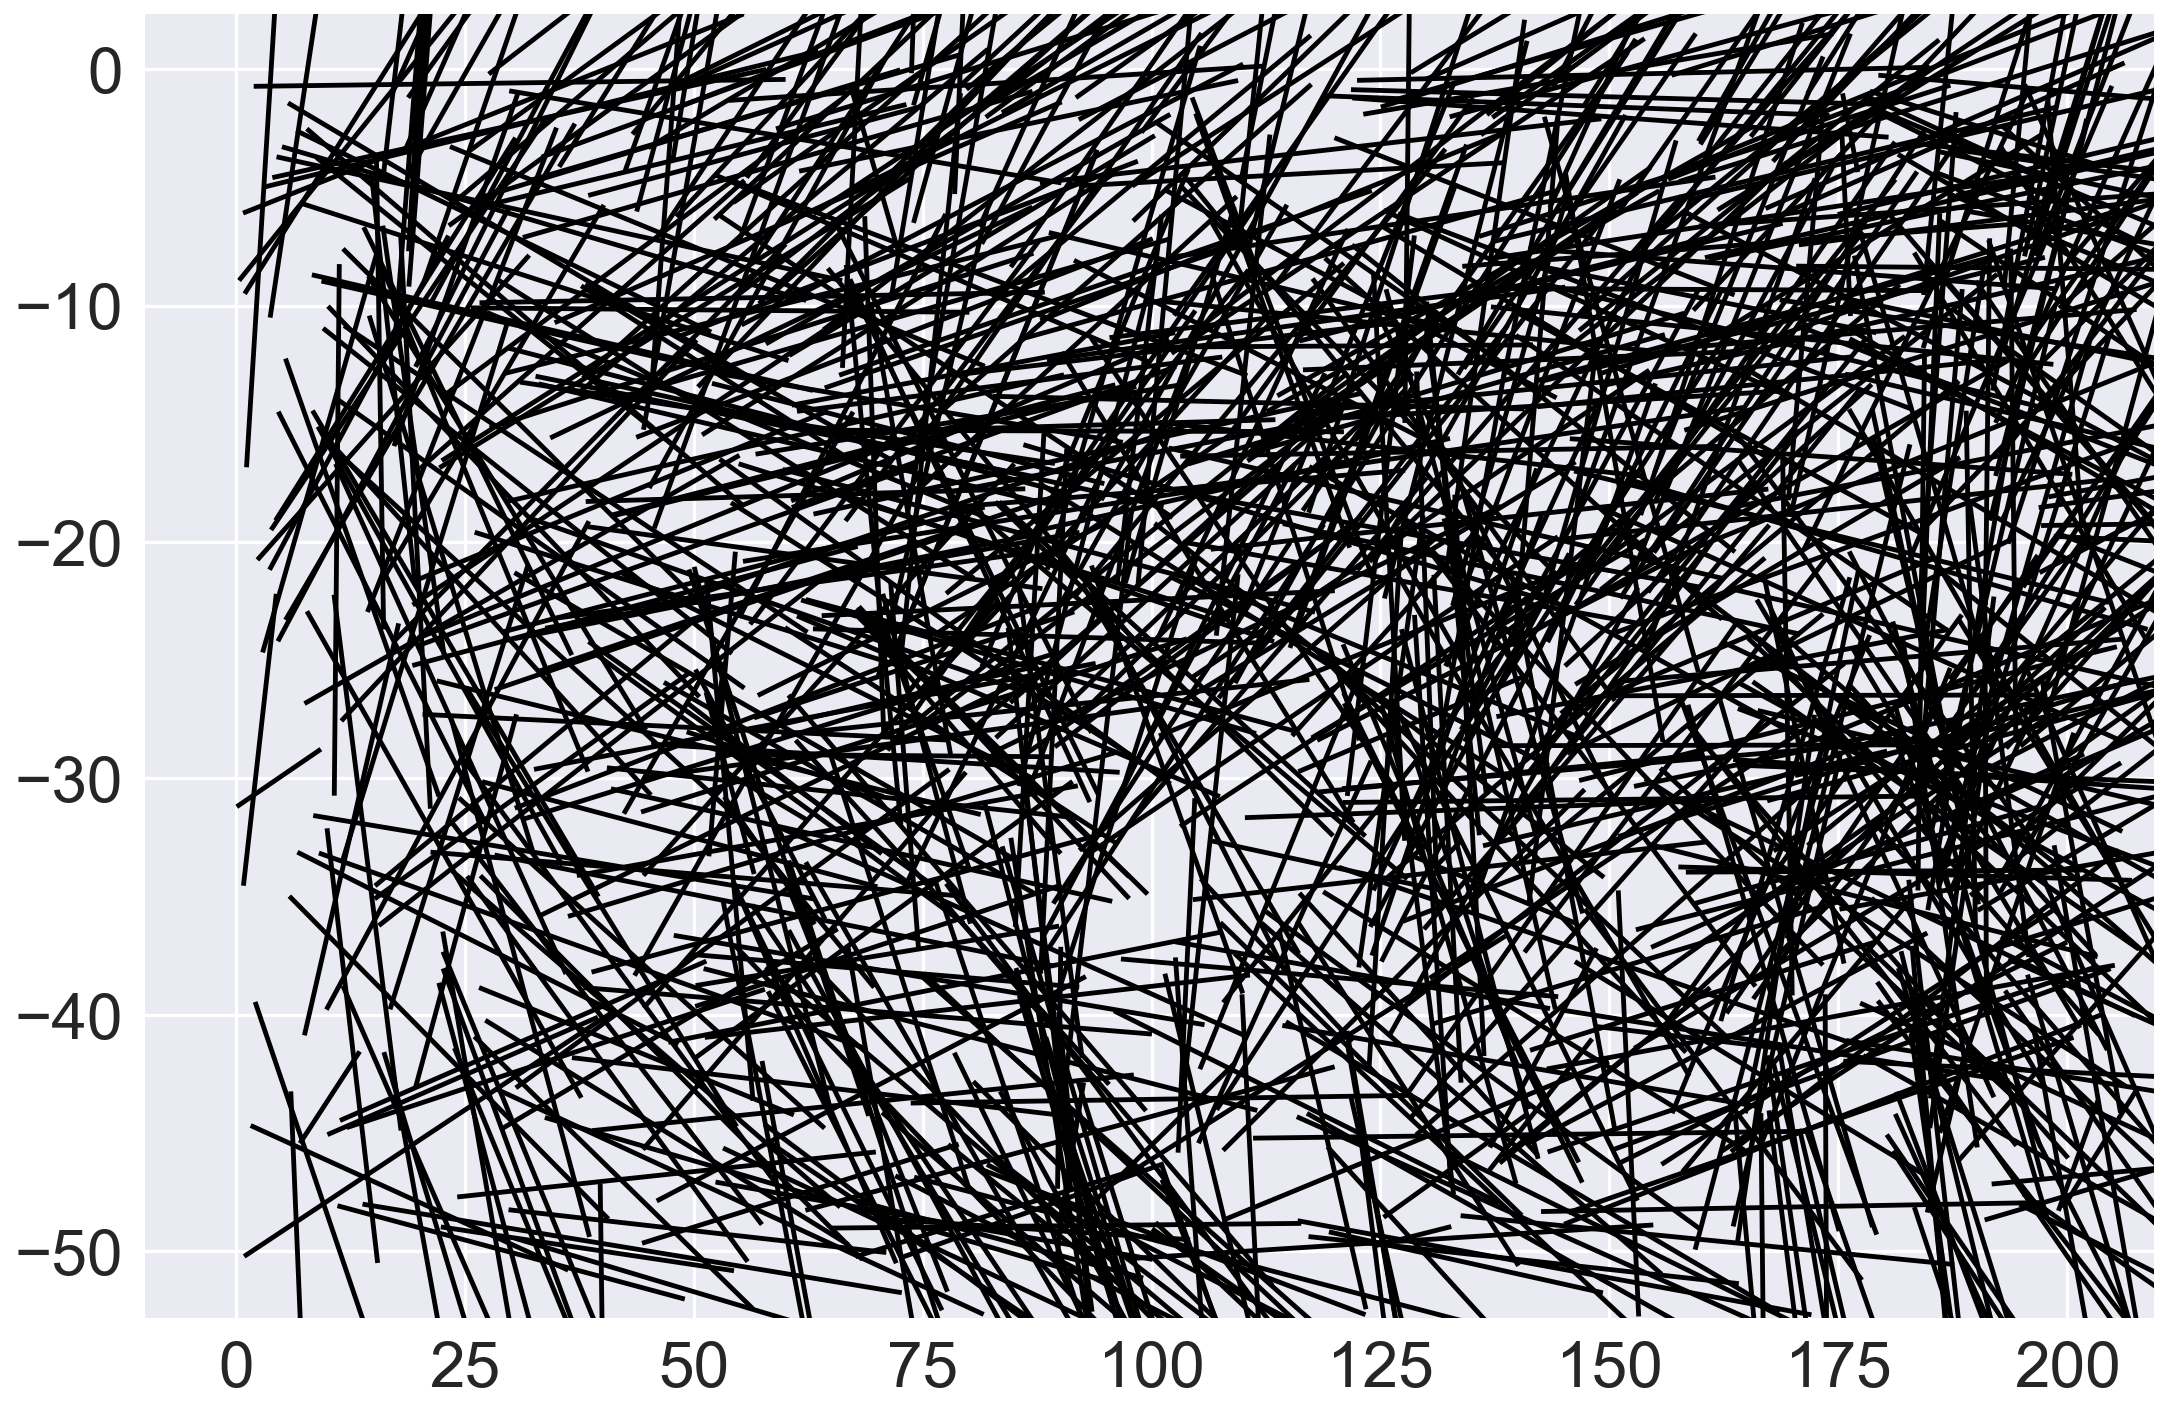

In [36]:
Q = plt.quiver(pixel_scale*X,Y*pixel_scale,U,V,angles=angles,
               headlength=0,headaxislength=0,scale=1/4,cmap='viridis')
print np.mean(U)


In [34]:
# X = np.array(worst_case.STAR.e.keys())[:,0]
# Y = np.array(worst_case.STAR.e.keys())[:,1]
# e1 = np.array(worst_case.STAR.e.values())[:,0]
# e2 = np.array(worst_case.STAR.e.values())[:,1]
# angles = np.zeros(len(X))
# U = np.sqrt(e1**2+e2**2)
# for i in range(len(U)):
#     angles[i] = r2d(0.5*np.arctan2(e2[i],e1[i]))
# pixel_scale = r2d(1)
# V = np.zeros(np.shape(U))
Q = plt.quiver(pixel_scale*X,Y*pixel_scale,U,V,angles=angles,
               headlength=0,headaxislength=0,scale=1/4,cmap='viridis')
plt.xlabel('RA (degrees)')
plt.ylabel('dec (degrees)')
# qk = plt.quiverkey(Q, 0.8, 0.85, 0.01, r'$|e|=0.01$', labelpos='E', coordinates='figure')
plt.title(r'median residual elipticity: {:.3f} '.format(np.median(U)))
# print np.mean(U)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


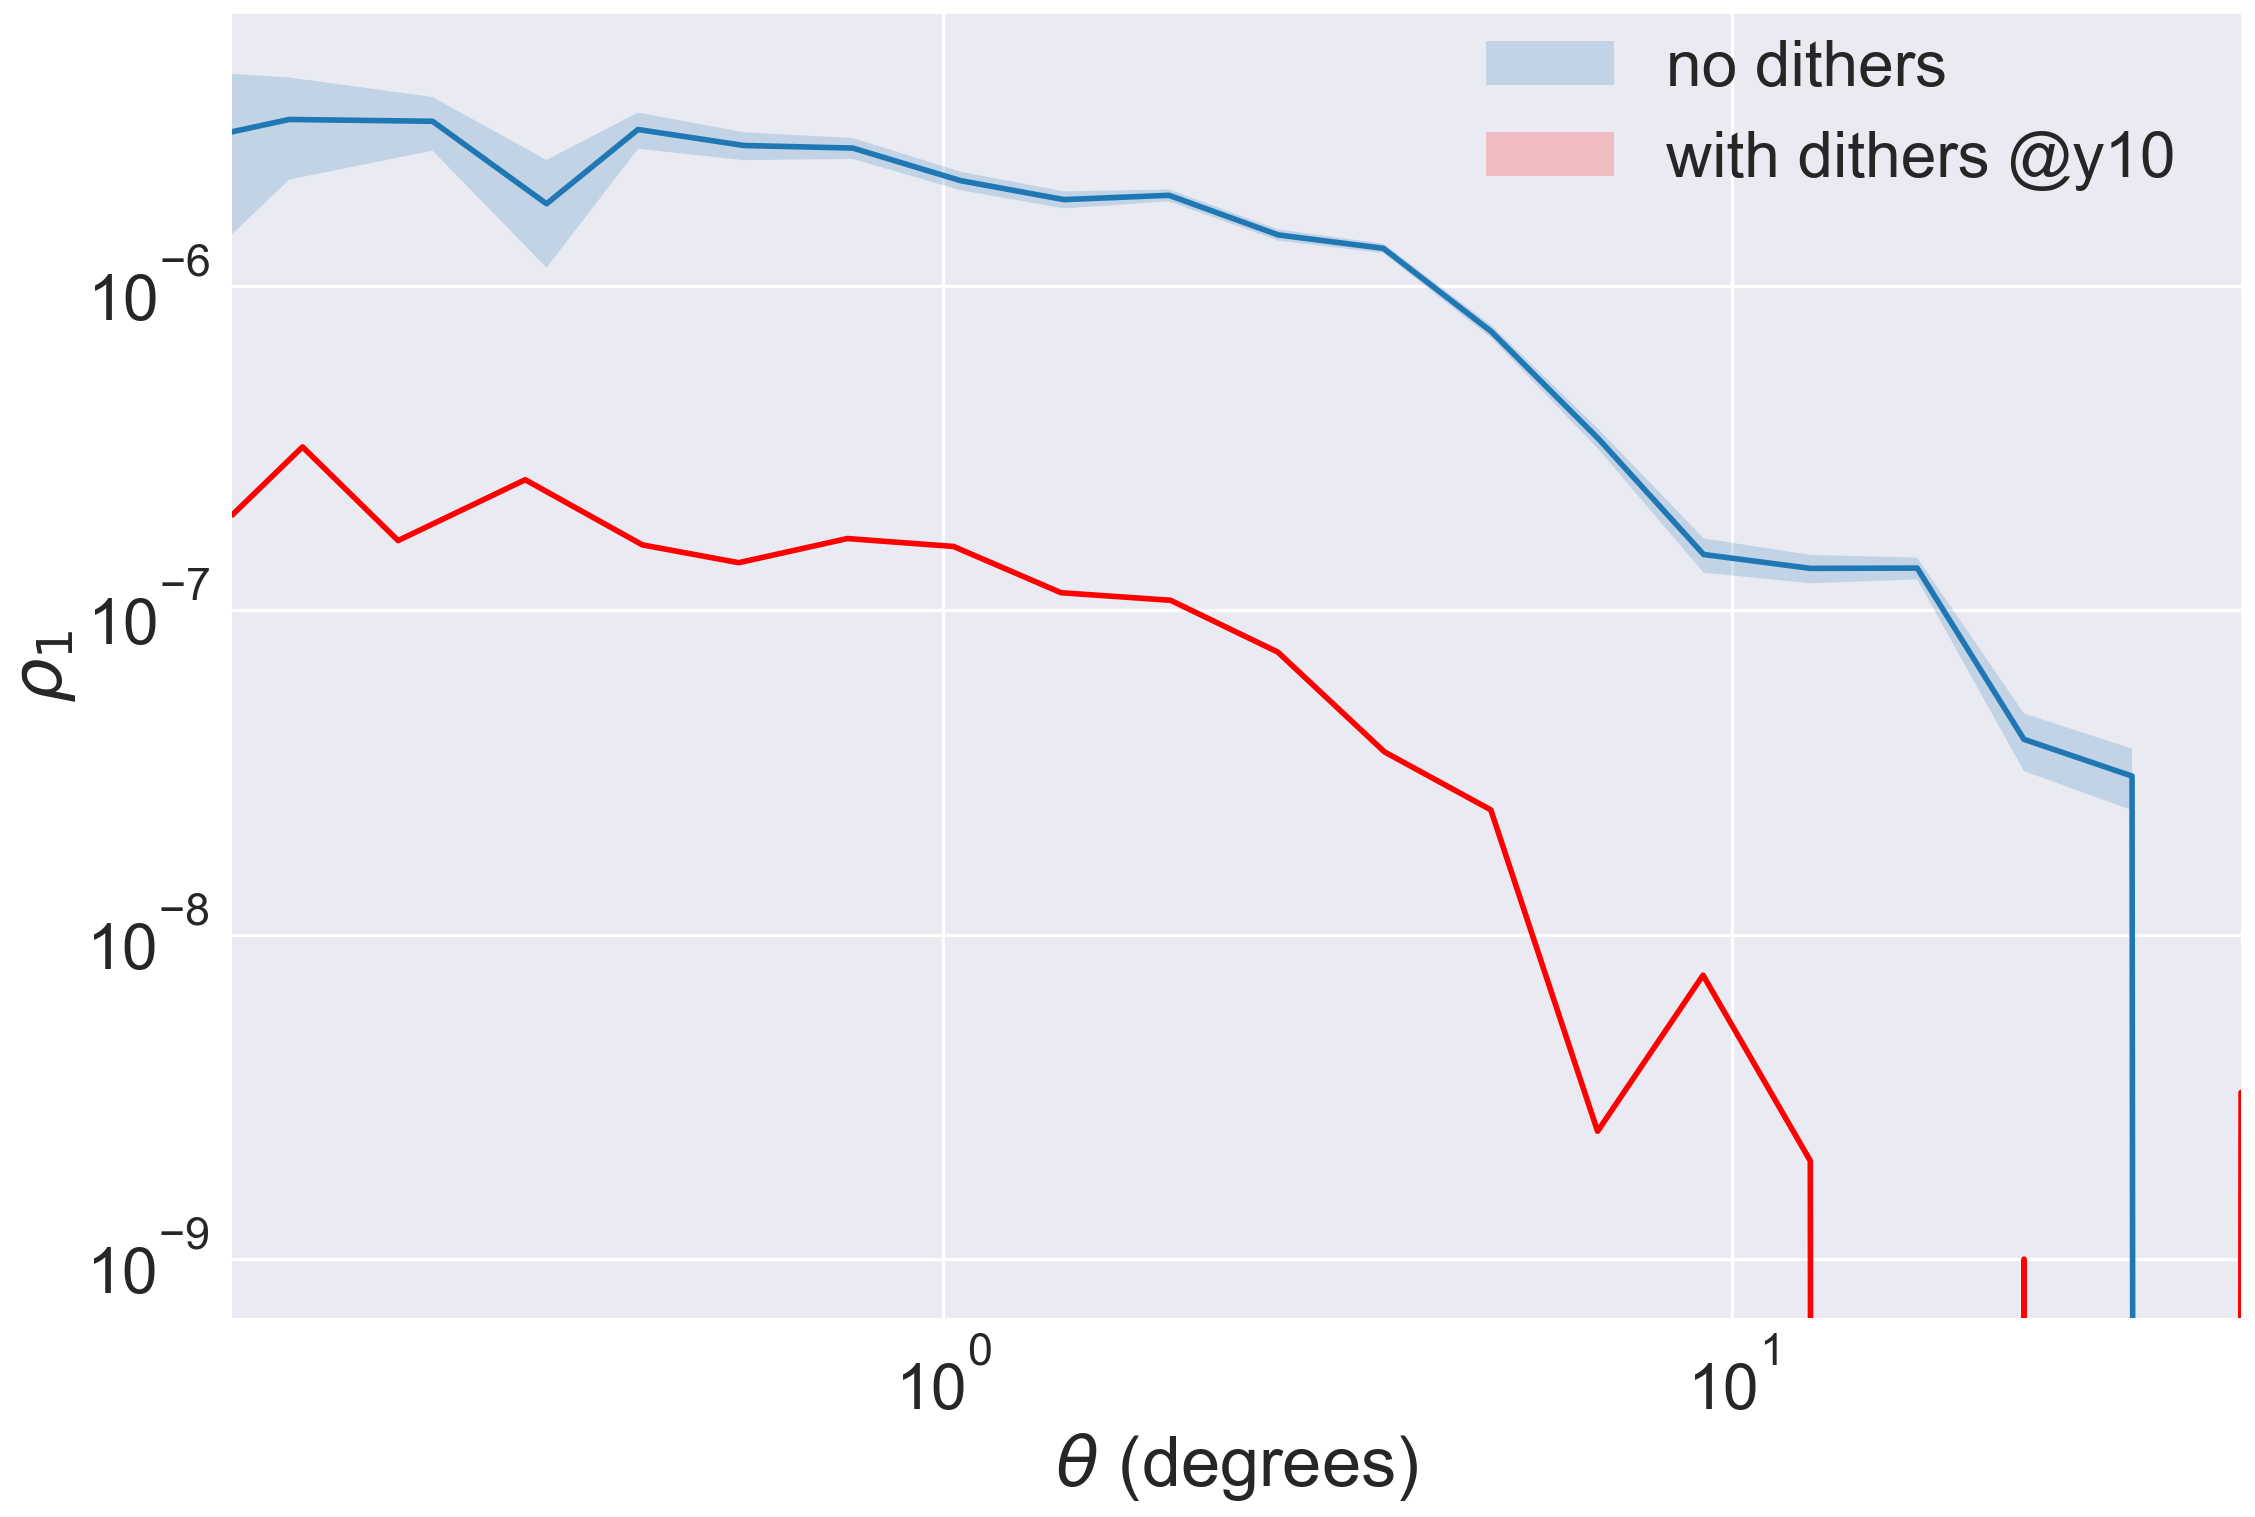

In [41]:
cat = treecorr.Catalog(g1=e1, g2=e2, ra=X, dec=Y,ra_units='radians',dec_units='radians')
gg = treecorr.GGCorrelation(min_sep=0.1, max_sep=50, nbins=20, sep_units='degrees')
gg.process(cat)
xip = gg.xip
xim = gg.xim
sigma = gg.varxi**0.5
def _plot_std_bars(std=None, central_data=None, ci=None, data=None,*args, **kwargs):
    std = sigma
    ci = np.asarray((central_data - std, central_data + std))
    kwargs.update({"central_data": central_data, "ci": ci, "data": data})
    seaborn.timeseries._plot_ci_band(*args, **kwargs)
seaborn.timeseries._plot_std_bars = _plot_std_bars
r = np.exp(gg.meanlogr)
sns.tsplot(xip,r,err_style='std_bars')

sns.tsplot(best_case.rho1,best_case.r,color='r')
# sns.tsplot(xim,r,err_style='std_bars',color='r')
plt.xlabel(r'$\theta$ (degrees)')
plt.ylabel(r'$\rho_1$')
plt.xscale('log')
plt.yscale('log')
# plt.yscale('symlog')
# plt.ylim(-1E-5, 5E-3)
plt.legend([r'no dithers',r'with dithers @y10'],bbox_to_anchor=(0.98, 1), loc='upper right', borderaxespad=0.)

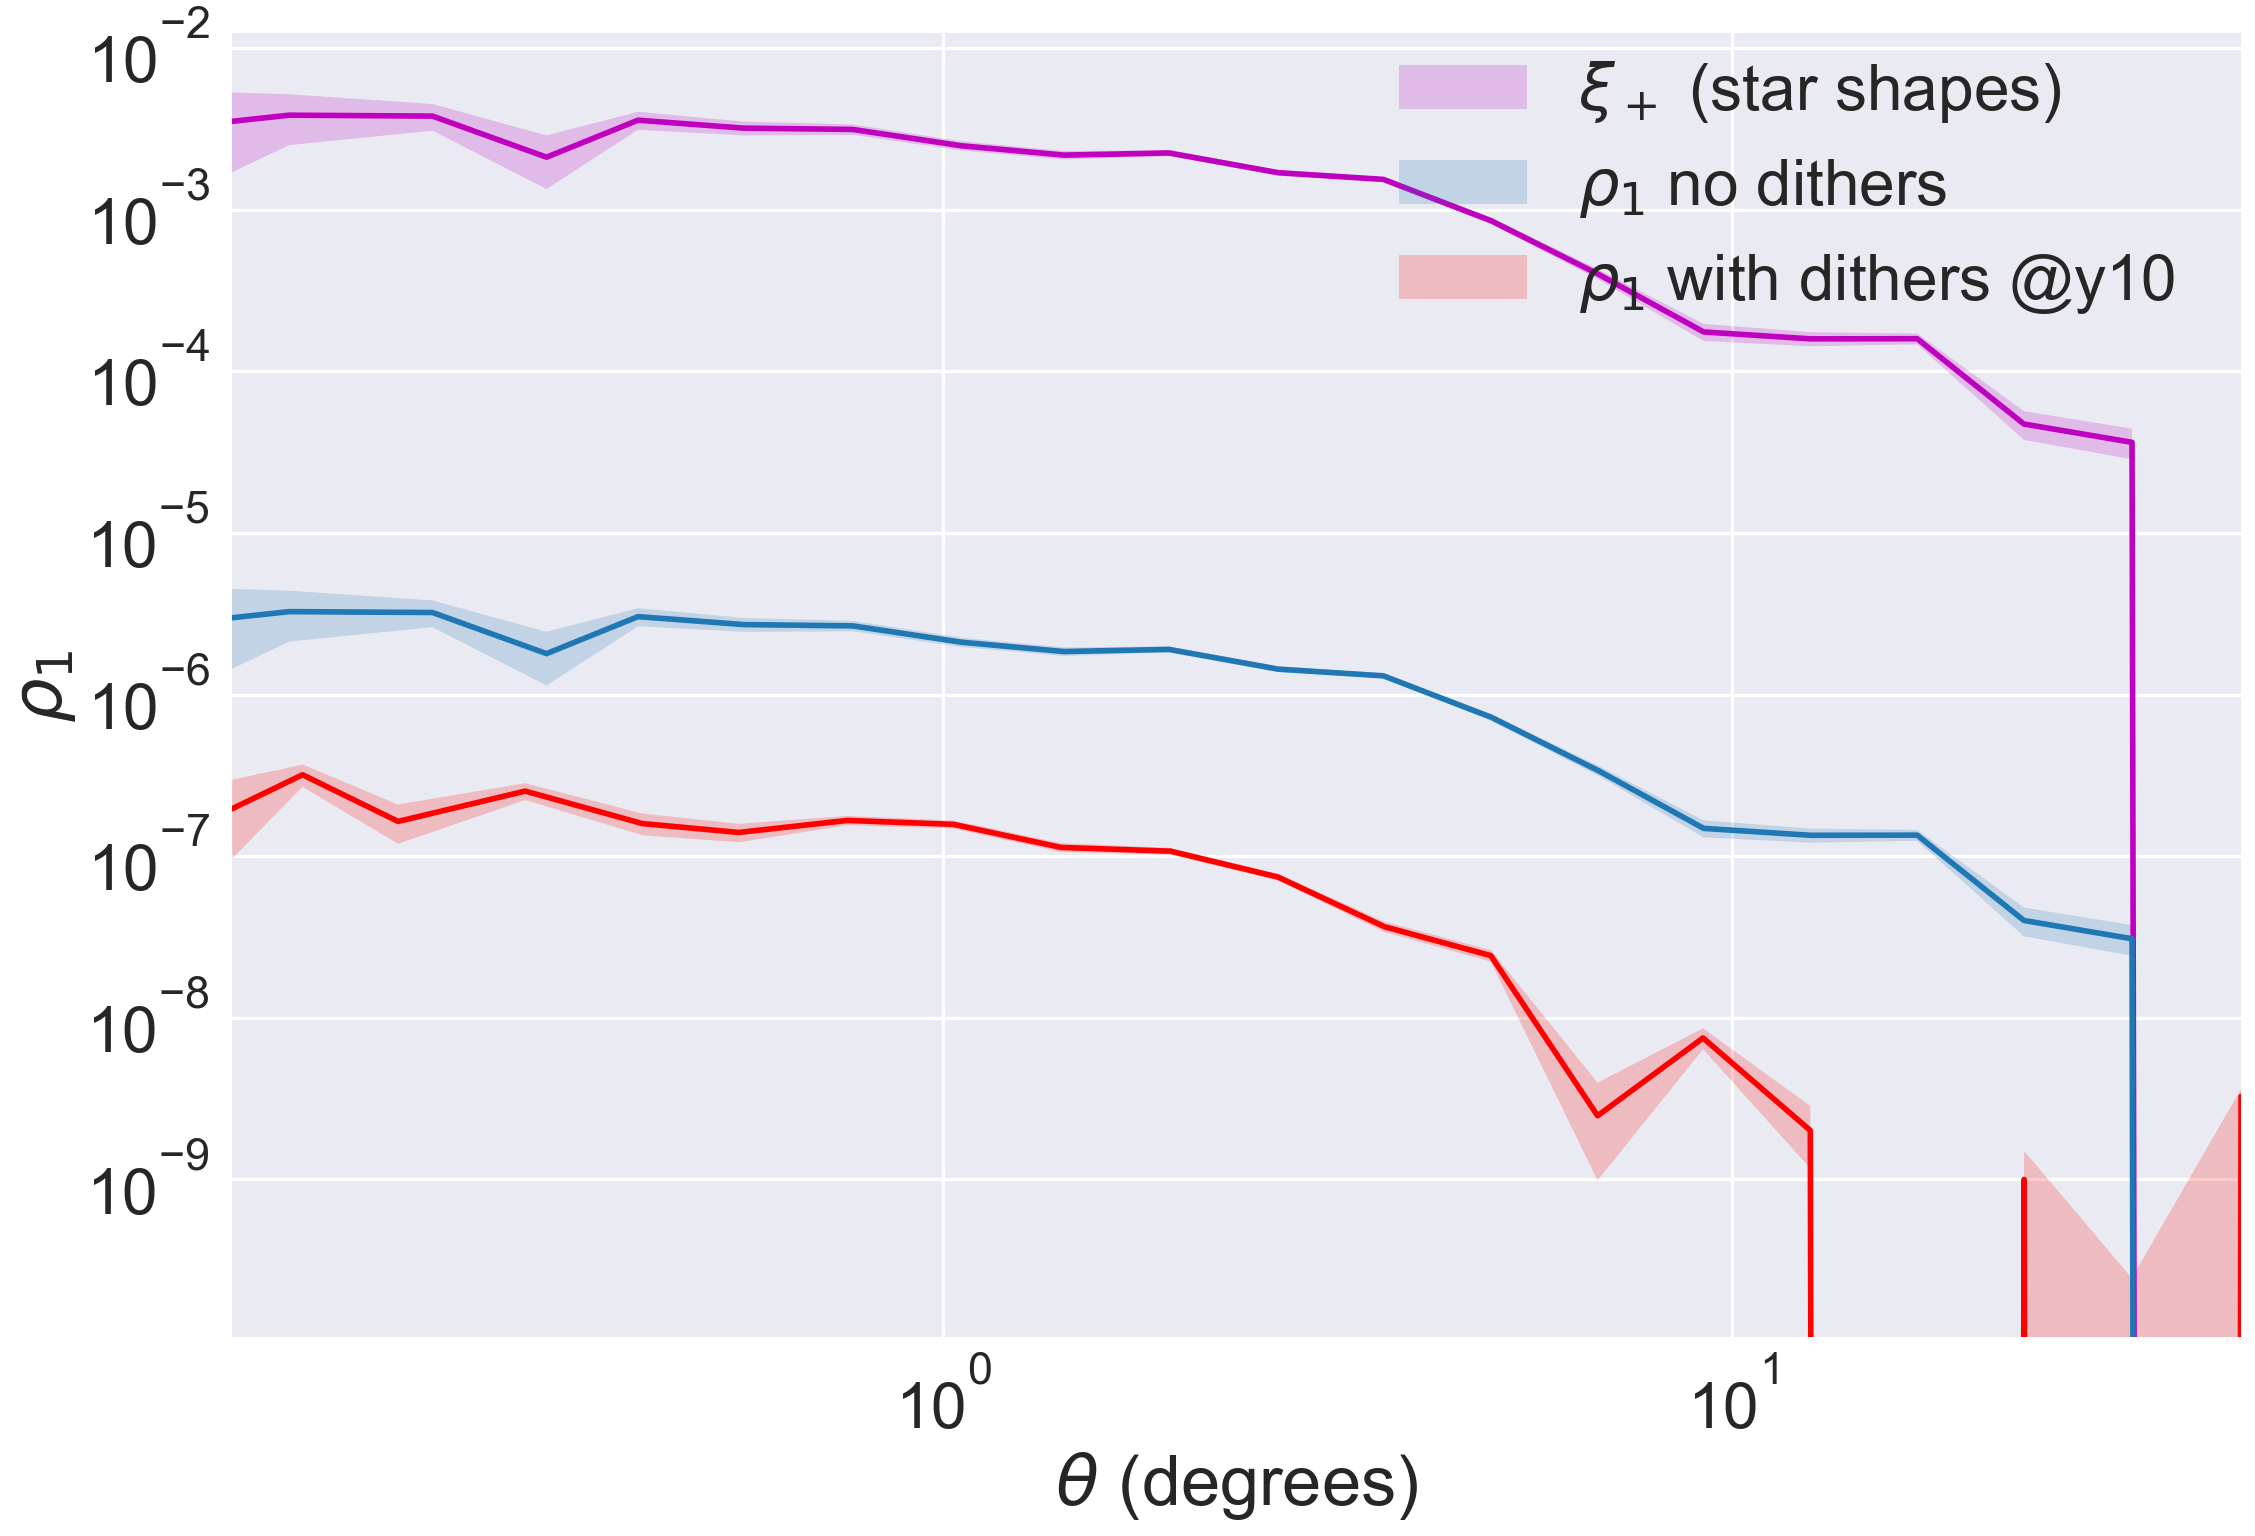

In [56]:

X = np.array(worst_case.STAR.e.keys())[:,0]
Y = np.array(worst_case.STAR.e.keys())[:,1]
e1 = np.array(worst_case.STAR.e.values())[:,0]
e2 = np.array(worst_case.STAR.e.values())[:,1]

cat = treecorr.Catalog(g1=e1, g2=e2, ra=X, dec=Y,ra_units='radians',dec_units='radians')
gg = treecorr.GGCorrelation(min_sep=0.1, max_sep=50, nbins=20, sep_units='degrees')
gg.process(cat)
xip = gg.xip
xim = gg.xim
sigma = gg.varxi**0.5

def _plot_std_bars(std=None, central_data=None, ci=None, data=None,*args, **kwargs):
    std = sigma
    ci = np.asarray((central_data - std, central_data + std))
    kwargs.update({"central_data": central_data, "ci": ci, "data": data})
    seaborn.timeseries._plot_ci_band(*args, **kwargs)
seaborn.timeseries._plot_std_bars = _plot_std_bars
r = np.exp(gg.meanlogr)
sns.tsplot(xip,r,err_style='std_bars',color='m')
X = np.array(worst_case.e.keys())[:,0]
Y = np.array(worst_case.e.keys())[:,1]
e1 = np.array(worst_case.e.values())[:,0]
e2 = np.array(worst_case.e.values())[:,1]
angles = np.zeros(len(X))

cat = treecorr.Catalog(g1=e1, g2=e2, ra=X, dec=Y,ra_units='radians',dec_units='radians')
gg = treecorr.GGCorrelation(min_sep=0.1, max_sep=50, nbins=20, sep_units='degrees')
gg.process(cat)
xip = gg.xip
xim = gg.xim
sigma = gg.varxi**0.5
def _plot_std_bars(std=None, central_data=None, ci=None, data=None,*args, **kwargs):
    std = sigma
    ci = np.asarray((central_data - std, central_data + std))
    kwargs.update({"central_data": central_data, "ci": ci, "data": data})
    seaborn.timeseries._plot_ci_band(*args, **kwargs)
seaborn.timeseries._plot_std_bars = _plot_std_bars
r = np.exp(gg.meanlogr)
sns.tsplot(xip,r,err_style='std_bars')




X = np.array(best_case.DELTA.e.keys())[:,0]
Y = np.array(best_case.DELTA.e.keys())[:,1]
e1 = np.array(best_case.DELTA.e.values())[:,0]
e2 = np.array(best_case.DELTA.e.values())[:,1]

cat = treecorr.Catalog(g1=e1, g2=e2, ra=X, dec=Y,ra_units='radians',dec_units='radians')
gg = treecorr.GGCorrelation(min_sep=0.1, max_sep=50, nbins=20, sep_units='degrees')
gg.process(cat)
xip = gg.xip
xim = gg.xim
sigma = gg.varxi**0.5

def _plot_std_bars(std=None, central_data=None, ci=None, data=None,*args, **kwargs):
    std = sigma
    ci = np.asarray((central_data - std, central_data + std))
    kwargs.update({"central_data": central_data, "ci": ci, "data": data})
    seaborn.timeseries._plot_ci_band(*args, **kwargs)
sns.tsplot(xip,best_case.r,err_style='std_bars',color='r')
# sns.tsplot(xim,r,err_style='std_bars',color='r')
plt.xlabel(r'$\theta$ (degrees)')
plt.ylabel(r'$\rho_1$')
plt.xscale('log')
plt.yscale('log')
# plt.yscale('symlog')
# plt.ylim(-1E-5, 5E-3)
plt.legend([r'$\xi_+$ (star shapes)',r'$\rho_1$ no dithers',r'$\rho_1$ with dithers @y10'],bbox_to_anchor=(0.98, 1), loc='upper right', borderaxespad=0.)